# "Concevez une application au service de la santé publique"
_Analysis Notebook_

In [1]:
# Checking whether the notebook is on Colab or PC

import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [2]:
# Mounting myDrive if on colab

if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


In [3]:
# Setting the current working directory

import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET3':
    os.chdir('My Drive/--DATA SCIENCE/PROJET3')

In [4]:
# Noticing user about files that has to be in the current working directory

def file_required(file_name):
    if os.path.exists(os.getcwd()+"/"+file_name):
        print("OK, loading "+file_name+"\
                           from the current working directory ...")
    else:
        print("Please, put "+file_name+"\
                           in the current working directory")

In [5]:
# Installations and importations required for Google Colab version
# (You may need to reboot the environment)

if is_colab==True:
    !pip install -r "requirements_analysis.txt"
else:
    # make sure 'requirements_analysis.txt' is in the current working directory
    file_required('requirements_analysis.txt')
    !pip install -r requirements_analysis.txt

  Using cached https://files.pythonhosted.org/packages/68/00/25013f7310a56d17e1ab6fd885d5c1f216b7123b550d295c93f8e29d372a/asgiref-3.2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fc/c0/731dfd39c7b1e25db613396a6b0549445eb287b7b543092d1677caed8f44/boto3-1.13.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/42/1f/848286ef5990c6dfac07095b8446313c4163e450025f014df02c860867ef/botocore-1.16.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2f/a6/30b0a0bef12283e83e58c1d6e7b5aabc7acfc4110df81a4471655d33e704/cachetools-3.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/2b/26e37a4b034800c960a00c4e1b3d9ca5d7014e983e6e729e33ea2f36426c/certifi-2020.4.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/59/aa63339001ca8e15ebb560d0c33333ef465c479e165d967e64c7611b6e67/chainer-6.5.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/b0/37/

In [6]:
!pip install ppscore==0.0.2
!pip install simplejson
!pip install mlxtend==0.17.2

In [8]:
# Importing modules 

import os
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import simplejson as json
import missingno as msno
import ppscore as pps
import warnings
warnings.filterwarnings('ignore')

import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import kpss, adfuller

from scipy.stats import f_oneway, kruskal, rankdata
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

plt.rcParams['figure.facecolor']='w'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# Importing cleaned dataset

# -- Getting list of dtype from json
f = open('d_types.json', 'r')
d_types = json.loads(f.read().replace('datetime64', 'object'))

# -- Importing
df = pd.read_csv('OFF_Cleaned.csv',
                 index_col='Unnamed: 0', dtype=d_types,
                 low_memory=False, encoding ='utf-8')
df['created_datetime'] = pd.to_datetime(df['created_datetime'])

In [10]:
# Setting your choice to save figures or not
plot_enabled = True

## 0 Preliminaries

Let's print the main infos on the dataframe as a guideline for further exploration.

In [11]:
def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

In [12]:
print(df.shape)
print_null_pct(df)

(557556, 45)
nb of null:  2101944 
pct of null:  8.4


In [13]:
# Checking columns in df

for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore | nutrigrade | nova_group | fat_100g | saturated_fat_100g | 
carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | salt_100g | sodium_100g | 
energy_from_fat_kj_100g | energy_kj_100g | ing_from_palm_oil_n | 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557556 entries, 3 to 1389835
Data columns (total 45 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   code                     557556 non-null  object             
 1   code_val                 557556 non-null  float64            
 2   categories_main          557556 non-null  object             
 3   categories_tuple         557556 non-null  object             
 4   url                      557556 non-null  object             
 5   main_category            557556 non-null  object             
 6   quantity_unit            200374 non-null  object             
 7   quantity_num             200276 non-null  float64            
 8   serving_quantity         321877 non-null  float64            
 9   quantity_type            201605 non-null  object             
 10  labels_main              557556 non-null  object             
 11  labels_tuple

In [15]:
# Displaying number of missing values per column

def plot_export_missing(df, cols, title, shorten_label=False, figsize=(12,8)):
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                        for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)

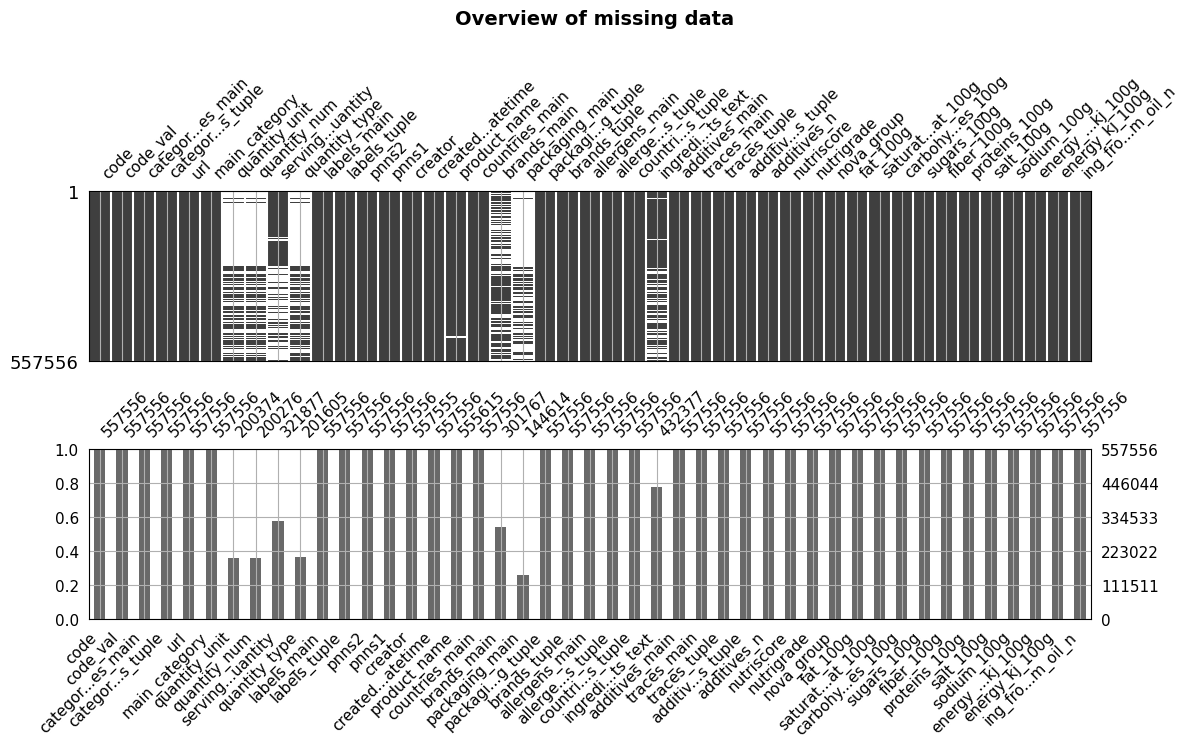

In [16]:
plot_export_missing(df, df.columns,'Overview of missing data',
                    shorten_label=True)
if plot_enabled:
    if not os.path.exists(os.getcwd()+'/FIG'): os.makedirs('FIG')
    plt.savefig(os.getcwd()+'/FIG/'+'A_0_missing_vals.png', dpi=400);
plt.show()

To help exploration, we'll split the data in groups. For more details about these groups, see the paragraph 6 (imputations) of P3_Cleaning notebook.

'C' indicate categorical columns and 'Q' quantitative columns. Columns name including 1 to 3 are without missing data whereas columns 4 may contain NaN and will have to be explored as subsets.

In [17]:
# Splitting columns in categories

info_cols =  ['code','code_val','url','creator','created_datetime',
              'product_name', 'ingredients_text']
cols_1_Q = ['nutriscore','fat_100g','carbohydrates_100g','proteins_100g',
            'salt_100g','saturated_fat_100g', 'sugars_100g', 'sodium_100g',
            'energy_kj_100g','energy_from_fat_kj_100g']
cols_1_C = ['nutrigrade', 'countries_main', 'categories_main']
cols_1_C_ = ['countries_tuple', 'categories_tuple']

cols_2_Q = ['fiber_100g']
cols_2_C = ['nova_group', 'pnns1', 'pnns2', 'main_category']
cols_2_C_ = []

cols_3_Q = ['ing_from_palm_oil_n','additives_n']
cols_3_C = ['additives_main','labels_main','allergens_main', 'traces_main']
cols_3_C_ = ['additives_tuple','labels_tuple','allergens_tuple', 'traces_tuple']

cols_4_Q = ['quantity_num', 'serving_quantity']
cols_4_C = ['brands_main','packaging_main', 'quantity_type','quantity_unit']
cols_4_C_ = ['brands_tuple','packaging_tuple']

qual_cols = cols_1_C + cols_2_C + cols_3_C + cols_4_C
quant_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q

## 1 Univariate analysis

### 1.1 Quantitative data

Let's plot the histograms of quantitative data, as well as the mean, median and the mode.

#### Histograms

We notice that:
- most of the distributions have a peak at or around zero. This can't completely be dismissed as an accumulation of wrong values as some products really contain zero fats or sugar or carbohydrates
- none of the distributions seems to be normal
- most distribution are positively skewed except nutriscore
- nutriscore has a bimodal distribution

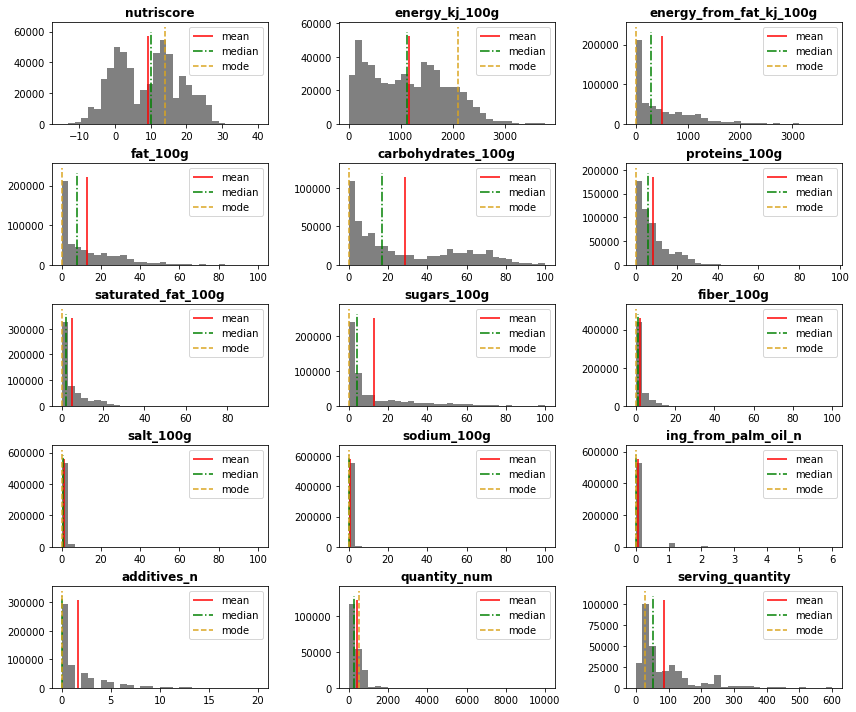

In [18]:
# Plotting histograms of the main quantitative continuous columns

# -- reordering columns
quant_cols = ['nutriscore', 'energy_kj_100g', 'energy_from_fat_kj_100g',
 'fat_100g','carbohydrates_100g','proteins_100g',
'saturated_fat_100g', 'sugars_100g', 'fiber_100g',
 'salt_100g','sodium_100g','ing_from_palm_oil_n',
 'additives_n', 'quantity_num', 'serving_quantity']

fig = plt.figure(figsize=(12,10))

# for i, ax, c in enumerate(zip(fig.ravel(), sorted(quant_cols))):
for i, c in enumerate(quant_cols,1):
    ax = fig.add_subplot(5,3,i)
    ax.hist(df[c],  bins=30, color='grey')
    ax.set_title(c)
    ax.vlines(df[c].mean(), *ax.get_ylim(),  color='red', ls='-', lw=1.5)
    ax.vlines(df[c].median(), *ax.get_ylim(), color='green', ls='-.', lw=1.5)
    ax.vlines(df[c].mode()[0], *ax.get_ylim(), color='goldenrod', ls='--', lw=1.5)
    ax.legend(['mean', 'median', 'mode'])
    ax.title.set_fontweight('bold')
    
# plt.tight_layout(w_pad=4.5, h_pad=-1)
plt.tight_layout(w_pad=2, h_pad=0.65)
# plt.gcf().set_size_inches(16,7)

if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_1_1_histograms.png',
                             dpi=400);
plt.show()

#### Normality test

It seems from histograms that none of the data is normally distributed. 

Let's check with usual normality tests and visualize the qqplots (for normal distribution).

In [19]:
# Normality Tests

from scipy.stats import shapiro, normaltest, anderson

def normality_tests(data, print_opt=False):
    res_df = pd.DataFrame([])
    data_notna = data[data.notna()]
    # Shapiro-Wilk - D'Agostino's K^2
    for f_name, func in zip(['Shapiro-Wilk', "D'Agostino K^2"],[shapiro, normaltest]):
        stat, p = func(data_notna)
        res_df.loc[f_name,'stat'] = stat
        res_df.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name) 
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        res_df.loc[f_name,'res'] = [p > 0.05]
        if p > 0.05:
            if print_opt: print('Probably Gaussian')
        else:
            if print_opt: print('Probably not Gaussian')
    # Anderson-Darling
    result = anderson(data_notna)
    if print_opt: print('---'+'Anderson-Darling')
    res_df.loc['Anderson-Darling','stat'] = result.statistic
    if print_opt: print('stat=%.3f' % (result.statistic))
    res_and = [(int(result.significance_level[i]),result.statistic < res)\
                   for i,res in enumerate(result.critical_values)]
    res_df.loc['Anderson-Darling','res'] = str(res_and)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            if print_opt: print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            if print_opt: print('Probably not Gaussian at the %.1f%% level' % (sl))
    return res_df

In [20]:
# Plotting histograms and qqplots of the main quantitative continuous columns

def plot_hist_qqplot(data, name, save=False):
    fig, axs = plt.subplots(1,2)
    # histogram
    axs[0].hist(data, histtype='stepfilled',ec='k', color='lightgrey', bins =25);
    # using statsmodels qqplot's module
    qqplot(data, line='r', **{'markersize': 5, 'mec': 'k','color': 'lightgrey'}, ax=axs[1])
    plt.gcf().set_size_inches(10,2.5)
    fig.suptitle(name, fontweight='bold', size=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])

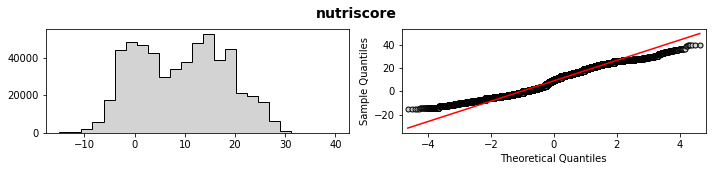

stat  ...                                                res
Shapiro-Wilk           0.974  ...                                              False
D'Agostino K^2   108,276.294  ...                                              False
Anderson-Darling   5,068.240  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

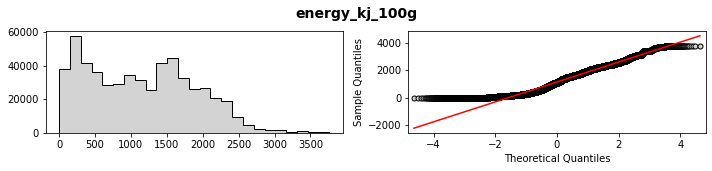

stat  ...                                                res
Shapiro-Wilk          0.961  ...                                              False
D'Agostino K^2   49,496.863  ...                                              False
Anderson-Darling  6,155.054  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

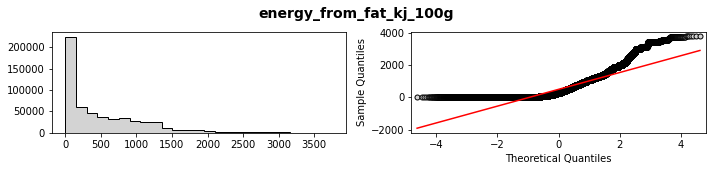

stat  ...                                                res
Shapiro-Wilk           0.820  ...                                              False
D'Agostino K^2   165,137.914  ...                                              False
Anderson-Darling  28,901.767  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

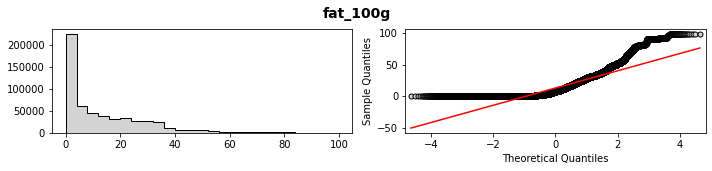

stat  ...                                                res
Shapiro-Wilk           0.820  ...                                              False
D'Agostino K^2   165,137.915  ...                                              False
Anderson-Darling  28,901.766  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

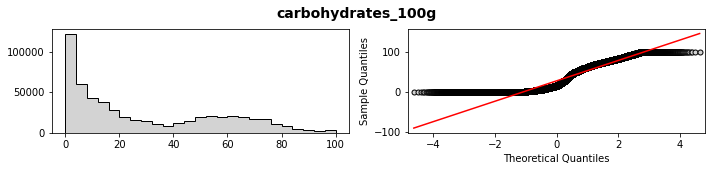

stat  ...                                                res
Shapiro-Wilk           0.876  ...                                              False
D'Agostino K^2   119,569.702  ...                                              False
Anderson-Darling  26,170.901  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

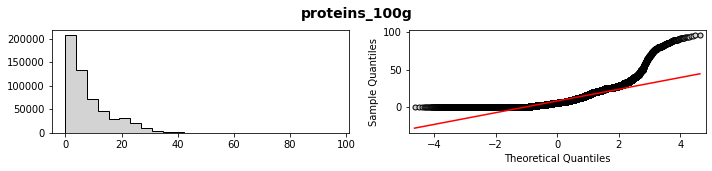

stat  ...                                                res
Shapiro-Wilk           0.824  ...                                              False
D'Agostino K^2   253,876.514  ...                                              False
Anderson-Darling  23,261.467  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

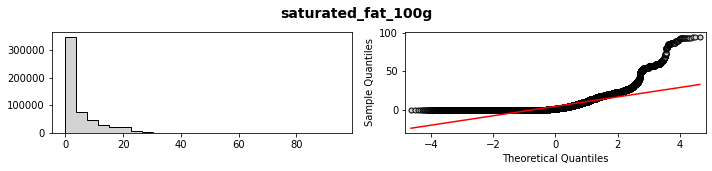

stat  ...                                                res
Shapiro-Wilk           0.715  ...                                              False
D'Agostino K^2   318,625.613  ...                                              False
Anderson-Darling  48,147.493  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

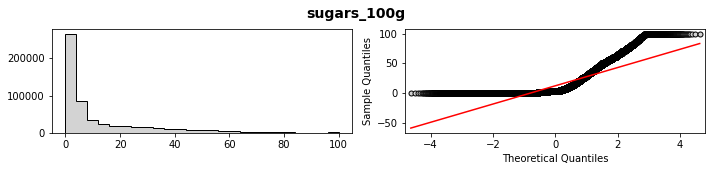

stat  ...                                                res
Shapiro-Wilk           0.720  ...                                              False
D'Agostino K^2   202,128.047  ...                                              False
Anderson-Darling  57,573.854  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

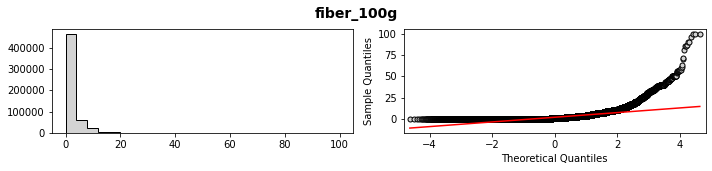

stat  ...                                                res
Shapiro-Wilk           0.635  ...                                              False
D'Agostino K^2   495,764.503  ...                                              False
Anderson-Darling  51,260.310  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

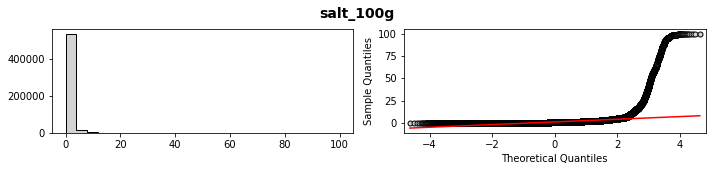

stat  ...                                                res
Shapiro-Wilk             0.236  ...                                              False
D'Agostino K^2   1,148,721.620  ...                                              False
Anderson-Darling   100,817.282  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

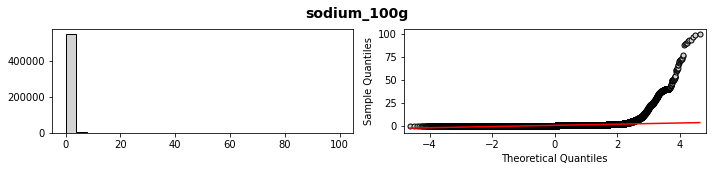

stat  ...                                                res
Shapiro-Wilk             0.193  ...                                              False
D'Agostino K^2   1,281,474.037  ...                                              False
Anderson-Darling   112,537.760  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

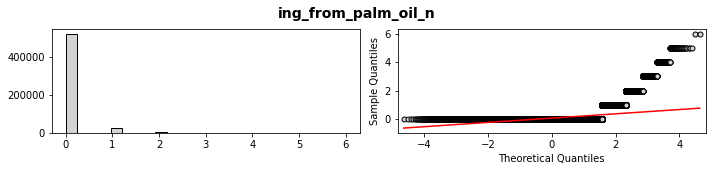

stat  ...                                                res
Shapiro-Wilk           0.231  ...                                              False
D'Agostino K^2   605,656.281  ...                                              False
Anderson-Darling 190,152.601  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

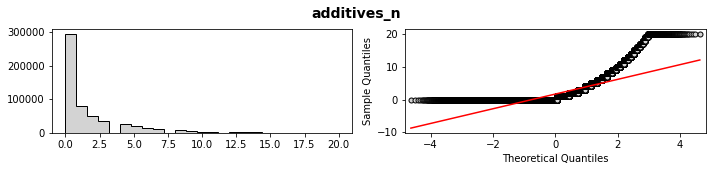

stat  ...                                                res
Shapiro-Wilk           0.661  ...                                              False
D'Agostino K^2   298,434.619  ...                                              False
Anderson-Darling  63,508.962  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

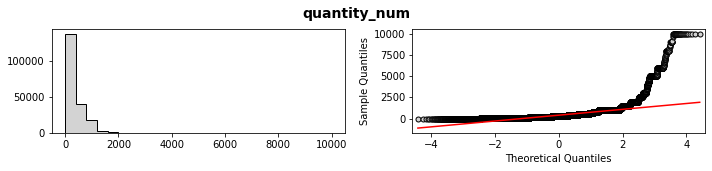

stat  ...                                                res
Shapiro-Wilk           0.574  ...                                              False
D'Agostino K^2   254,006.074  ...                                              False
Anderson-Darling  16,227.690  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

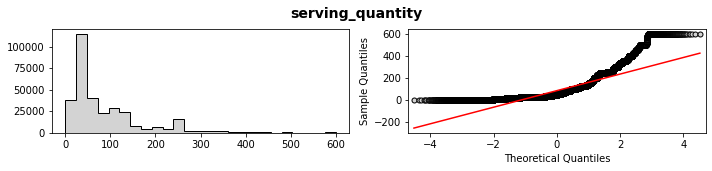

stat  ...                                                res
Shapiro-Wilk           0.770  ...                                              False
D'Agostino K^2   138,792.578  ...                                              False
Anderson-Darling  22,705.095  ...  [(15, False), (10, False), (5, False), (2, Fal...

[3 rows x 3 columns]

In [21]:
# Plotting QQplots and normality tests stats

for i, c in enumerate(quant_cols,1):
    if c in cols_4_Q:
        plot_hist_qqplot(df[c].dropna().values, c, save=False)
    else:
        plot_hist_qqplot(df[c].values, c, save=False)
    if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_1_1_qqplot_'+c+'.png', dpi=400)
    plt.show()
    with pd.option_context('display.float_format', '{:,.3f}'.format):
        display(normality_tests(df[c], print_opt=False))

Without surprise data are far from normal distribution. We'll have to take this into account while hypothesis testing.

### Boxplots

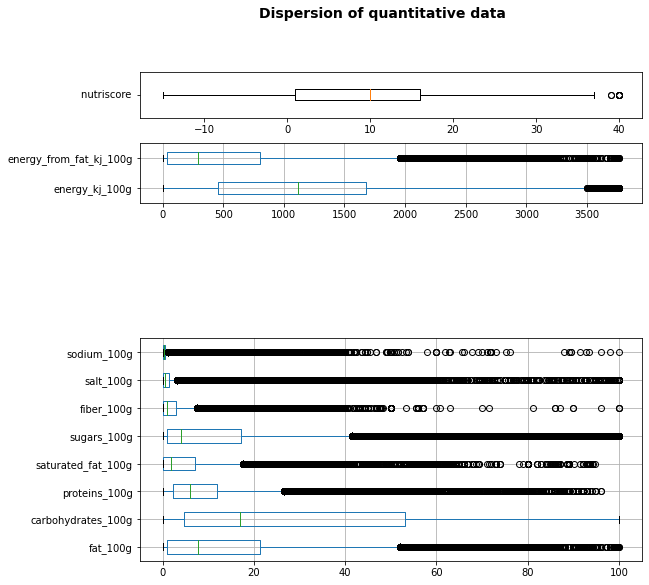

In [22]:
# Plotting boxplot of quantitative features for each nutrigrade

fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(9,1,1)
ax1.boxplot(df['nutriscore'], widths=[0.25], vert=False, patch_artist= False)
ax1.set_ylabel('nutriscore    ', rotation=0, va = 'center', fontsize=10, labelpad = 20)
ax1.set_yticklabels(['']*10)

ax2 = fig.add_subplot(7,1,2)
sel_cols = ['energy_kj_100g', 'energy_from_fat_kj_100g']
df[sel_cols].boxplot(vert=False, widths=[0.4,0.4], patch_artist= False, ax=ax2)

ax3 = fig.add_subplot(2,1,2)
sel_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',
            'saturated_fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g', 'sodium_100g']
df[sel_cols].boxplot(vert=False, patch_artist= False, ax=ax3)


# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Dispersion of quantitative data', fontsize=14,
             fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_boxplots.png',
                             dpi=400);
plt.show()

### 1.2 Qualitative data

Let's see how categorical data are distributed over categories.

For more clarity we plot only data of 15 most populated categories.

#### Bar plots

In [23]:
qual_cols = ['nutrigrade', 'pnns1', 'pnns2','brands_main',
 'countries_main', 'nova_group', 'categories_main', 'main_category',
 'additives_main', 'labels_main', 'allergens_main', 'traces_main',
 'packaging_main', 'quantity_type', 'quantity_unit']

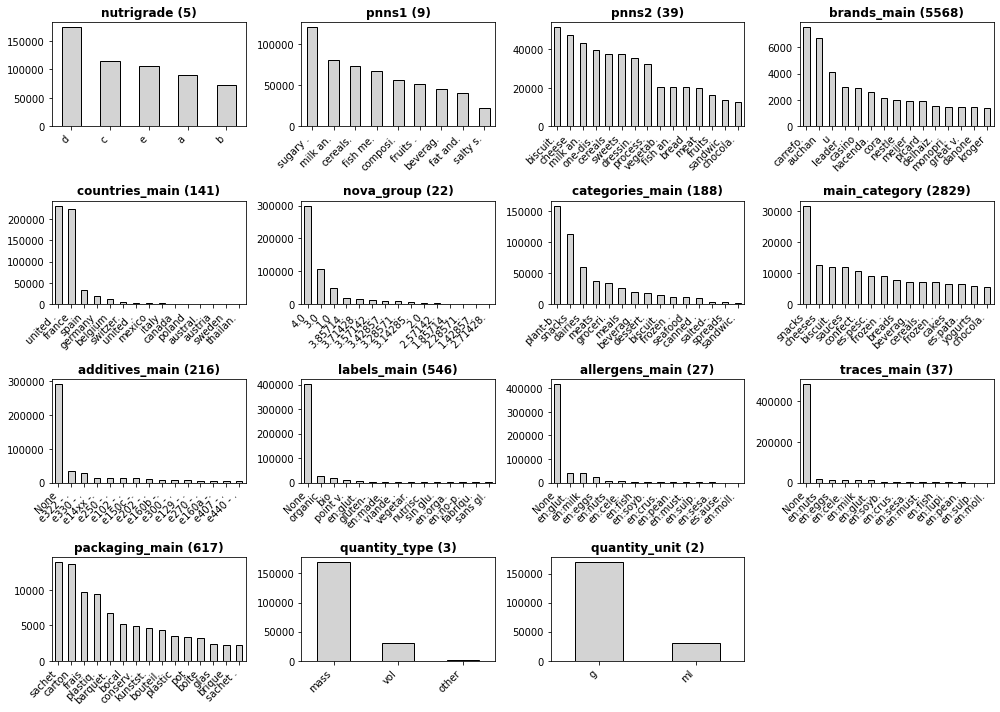

In [24]:
# Plotting bar plots of the main categorical columns

fig = plt.figure(figsize=(14,10))
for i, c in enumerate(qual_cols,1):
    ax = fig.add_subplot(4,4,i)
    ser = df[c].value_counts()
    n_cat = ser.shape[0]
    if n_cat>15:
        ser[0:15].plot.bar(color='lightgrey',ec='k', ax=ax)
    else:
        ser.plot.bar(color='lightgrey',ec='k',ax=ax)
    ax.set_title(c+f' ({n_cat})', fontweight='bold')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [s[0:7]+'.' if len(s)>7 else s for s in labels]
    ax.axes.set_xticklabels(short_labels)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_1_2_bar_plots.png', dpi=400);
plt.show()

Some features have lots of categories ('main category', 'brands_main', 'labels_main', 'packaging_main'), whereas others ('nutrigrade', 'nova_group', 'pnns1' 'pnns2' have less.

## 2 Time analysis

We'll define useful functions for time analysis of data presented below.

### 2.0 Functions

In [25]:
# Plotting heatmap (3 options available, rectangle,
# triangle of table of contingency)

def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    fig, ax = plt.subplots(figsize=figsize)
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    palette = palette
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    ax.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)
    # return mask

In [26]:
# Plotting proportion of categories among newly entered products and returning
# the dataframe of aggregated data for each categories

def plot_cat_prop_thr_time(col, palette='dark', ncol=3):
    
    fig = plt.figure(figsize=(10,5))
    gb = df.groupby(col)
    lab = gb.size().index
    # mean aggregation by month
    gb_week = df.groupby([pd.Grouper(key='created_datetime', freq='M'), col])
    cat_n_item_counts = gb_week.size().unstack()
    cat_n_item_prop = cat_n_item_counts\
         .div(cat_n_item_counts.sum(axis='columns').values/100, axis='rows')
    
    with sns.color_palette(palette):
        plt.stackplot(cat_n_item_prop.index, cat_n_item_prop.T.values,
                      alpha=0.8, labels=cat_n_item_prop.columns)

    ax = plt.gca()
    plt.legend(bbox_to_anchor=[0.9,-0.1], ncol=ncol)
    ax.set_xlabel("Time"), ax.set_ylabel("Category proportions (%)")
    ax.set_title("Proportion of each category among new items ("+col+")")
    plt.tight_layout(rect=[0, 0.05, 1, 1.2])
  
    return cat_n_item_prop

In [27]:
# Function calculating regression for each categories through time

def mult_reg_thr_time(df):
    data = df.dropna(how='any')
    dates = mdates.date2num(data.index)
    dates_rel = dates-dates.min()
    df_reg_prop = pd.DataFrame([])

    for c in df.columns:
        X = dates_rel
        y = data[c].values
        X, y = [arr.reshape(-1, 1) for arr in [X,y]]
        reg = LinearRegression()
        reg.fit(X,y)
        reg.score(X, y)
        df_reg_prop.loc['coef', c] = reg.coef_[0,0]
        df_reg_prop.loc['intercept',c] = reg.intercept_[0]
        df_reg_prop.loc['mean',c] = y.mean()
    return df_reg_prop

In [28]:
# Function applying stationary tests to data and returning if stat. or not

def stationary_tests(data, print_opt=True):

    data_m = np.array(data[~np.isnan(data)])
    stat, p, lags, crit = kpss(data_m, lags='auto')
    result = adfuller(data_m)

    if print_opt:

        # : H0 : series is not trend-stationary.
        print('--- Kwiatkowski---') 
        print('stat=%.3f, p=%.3f' % (stat, p))
        # not rejected -> series is not trend-stationary.
        print('prob. not trend-stationary') if p > 0.05\
             else print('prob. trend-stationary') # rejected -> trend-stationary
        
        # H0 there is a unit root i.e. series is non-stationary
        print('--- Aug. Dickey-Fuller ---\n stat.: %f' % result[0]) 
        print('p-value: %f' % result[1])
        # not rejected -> series is non-stationary
        print('prob. not stationary\n') if result[1] > 0.05\
                    else print('prob. stationary\n' )# rejected -> stationary
    # True : stationnary/trend-stationnary
    return {'Kwiatkowski': (round(p,4), str(p <= 0.05)),
            'Aug. Dickey-Fuller': (round(result[1],4), str(result[1] <= 0.05))}

In [29]:
# Plotting ANOVA and Kruskall-Wallis H test and return if same dist. or not

def id_cat_distrib_tests(data_df, Q_col, C_col, print_opt=True):

    gb = data_df.groupby(C_col)[Q_col]
    cat = list(gb.groups.keys())
    cat_series = [gr.dropna().values for n, gr in gb]

    if print_opt: print('oooooooo- {} vs. {} -oooooooo'.format(Q_col, C_col))

    # Analysis of Variance Test
    stat1, p1 = f_oneway(*cat_series)
    if print_opt:
        print('---ANOVA---')
        print('stat=%.3f, p=%.10f' % (stat1, p1))
        print('Prob. same distr') if p1 > 0.05 else print('Prob. different distr')
    # Kruskal-Wallis H Test
    stat2, p2 = kruskal(*cat_series)
    if print_opt:
        print('---Kruskal-Wallis---')
        print('stat={:.3f}, p={:.10f}'.format(stat2, p2))
        print('Prob. same distr') if p2 > 0.05 else print('Prob. different distr')
        
    return {'ANOVA': (round(p1,4), str(p1 > 0.05)),
            'Kruskal-Wallis': (round(p2,4), str(p2 > 0.05))}

 # - > at least one of the groups has a significantly different mean from the others.

In [30]:
# Testing each category for one chosen test

def mult_test(data_df, test_func, print_opt=True, res_df=pd.DataFrame(), **kwargs):

    res_df_mod = res_df.copy('deep')

    for c in data_df.select_dtypes(include=np.number).columns:
        if print_opt: print('oooo--'+c+'--oooo')
        if test_func=='stat':
            dic_stat = stationary_tests(data_df[c], print_opt=print_opt)
        elif test_func=='id_dist':
            dic_stat = id_cat_distrib_tests(data_df, C_col=kwargs['C_col'],
                                            Q_col=c, print_opt=print_opt)
        else:
            print('ERROR: this function does not exist')
        for s in dic_stat.keys():
            res_df_mod.loc[s,c] = str(dic_stat.get(s))

    return res_df_mod

### 2.1 New items through time
Let's plot the amount of new entries by periods of time. 

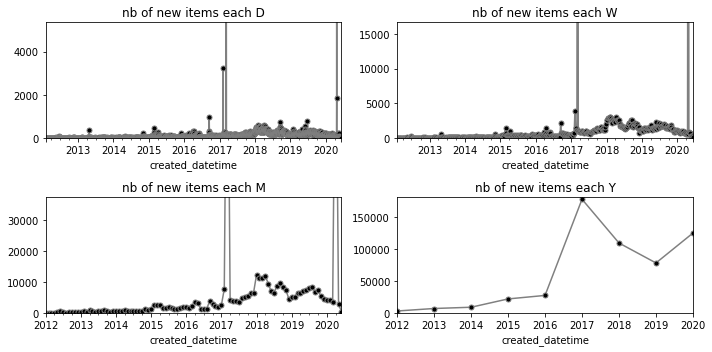

In [31]:
# Plotting number of new items through time

fig = plt.figure(figsize=(10,5))
for i,per in enumerate(['D', 'W', 'M', 'Y'],1):
    ax = fig.add_subplot(2,2,i)
    t_ser = df.groupby(pd.Grouper(key='created_datetime', freq=per)).size()
    t_ser.plot(ax=ax, ms=5, marker='o', mfc='k', color='grey', ls='-')
    ax.set(ylim=(0,np.mean(t_ser)+2*np.std(t_ser)))
    ax.set_title("nb of new items each "+per)
fig.tight_layout()
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_2_1_evol_new_items_rate.png', dpi=400);
plt.show()

We see that the rate of new entries per unit of time is globally increasing. However we notice that:
- there has been several times addition of huge amounts of data in 2017 and in 2020
- the rate of new products tend to decrease if we except the occasional addition of large amounts of data.

### 2.2 Proportion of categories through time

#### pnns1 categories

Let's see now is all categories are evenly represented among new products through time. We'll plot the proportion of new products in each categoriy of 'pnns1' (mean aggregation by 'months').

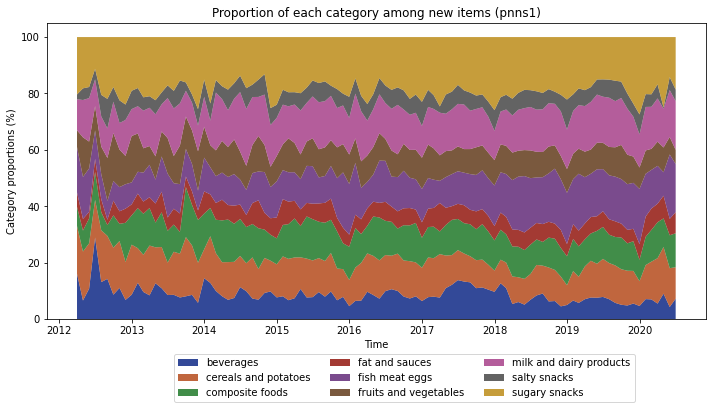

In [32]:
# Plotting proportion of pnns1 among newly entered items

pnns1_n_item_prop = plot_cat_prop_thr_time('pnns1')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_2_2_evol_prop_pnns1.png',
                               dpi=400);
plt.show()

A first glance at the graph indicate that the proportion of all categories seem globally stable through time.

Let's check with a regression:

In [33]:
# calculating regression for the proportion on new items
# for each pnns1 category through time

reg_pnns1_prop = mult_reg_thr_time(pnns1_n_item_prop)

In [34]:
reg_pnns1_prop

beverages  cereals and potatoes  ...  salty snacks  sugary snacks
coef       -0.001601             -0.001496  ...      0.000010       0.000283
intercept  11.171092             14.872060  ...      5.606241      18.775309
mean        8.759281             12.618814  ...      5.620569      19.201253

[3 rows x 9 columns]

For all categories, the intercept coefficient is fairly close to the mean value through time. That seem to indicate the proportion is stationary.

Let's check with proper stationary tests.
We'll use two different tests :
- Augmented Dickey-Fuller unit root test : tests the non-stationnarity (null hypothesis)
- Kwiatkowski-Phillips-Schmidt-Shin test : tests the non-trend-stationnarity (null hypothesis).

In [35]:
reg_pnns1_prop = mult_test(data_df = pnns1_n_item_prop, test_func = 'stat',
                           res_df=reg_pnns1_prop, print_opt=True)

oooo--beverages--oooo
--- Kwiatkowski---
stat=0.775, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -6.568037
p-value: 0.000000
prob. stationary

oooo--cereals and potatoes--oooo
--- Kwiatkowski---
stat=0.907, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -2.631327
p-value: 0.086694
prob. not stationary

oooo--composite foods--oooo
--- Kwiatkowski---
stat=0.273, p=0.100
prob. not trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -7.030915
p-value: 0.000000
prob. stationary

oooo--fat and sauces--oooo
--- Kwiatkowski---
stat=0.381, p=0.085
prob. not trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -6.926629
p-value: 0.000000
prob. stationary

oooo--fish meat eggs--oooo
--- Kwiatkowski---
stat=0.753, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -2.122254
p-value: 0.235661
prob. not stationary

oooo--fruits and vegetables--oooo
--- Kwiatkowski---
stat=0.911, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -

The stationary tests are not unanimous, however we can see on the summary table below that at least one of the two tests each time gives positive outcome, (i.e. proportion is stationary), as could be expected from coeffients of the linear regression.

In [36]:
reg_pnns1_prop

beverages  ...   sugary snacks
coef                   -0.00160079  ...     0.000282711
intercept                  11.1711  ...         18.7753
mean                       8.75928  ...         19.2013
Kwiatkowski         (0.01, 'True')  ...  (0.1, 'False')
Aug. Dickey-Fuller   (0.0, 'True')  ...   (0.0, 'True')

[5 rows x 9 columns]

#### nutrigrade

We can do the same analysis with nutrigrade groups:

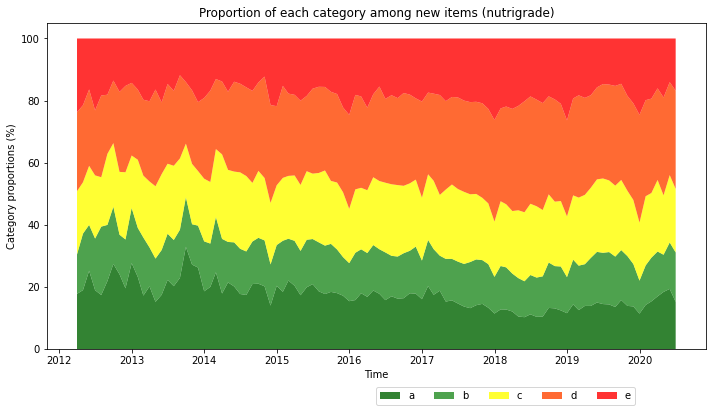

a  ...               e
coef                      -0.00340289  ...     0.000799098
intercept                     22.5255  ...         17.1756
mean                          17.3986  ...         18.3795
Kwiatkowski            (0.01, 'True')  ...  (0.1, 'False')
Aug. Dickey-Fuller  (0.5089, 'False')  ...   (0.0, 'True')

[5 rows x 5 columns]

In [37]:
# plotting graph, calculating regression and testing for stationarity

nutri_pal = ['darkgreen', 'forestgreen', 'yellow', 'orangered', 'red']

nutrig_n_item_prop = plot_cat_prop_thr_time('nutrigrade', palette=nutri_pal,
                                            ncol=5)
reg_nutrig_prop = mult_reg_thr_time(nutrig_n_item_prop)
reg_nutrig_prop = mult_test(data_df=nutrig_n_item_prop, res_df=reg_nutrig_prop,
                            test_func='stat', print_opt=False)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_2_2_evol_prop_nutrigrade.png',
                             dpi=400);
plt.show()
reg_nutrig_prop

It seems that the ratio of A nutrigrade products has decreased from 2012 to mi-2018, and increased again up to now, whereas the ratio of nutrigrade D products increased progressively.  

### 2.3 Evolution of quantitative features

Let's now see if we can point out changes in some of the main quantitative features. We'll plot a rolling mean of features through time.

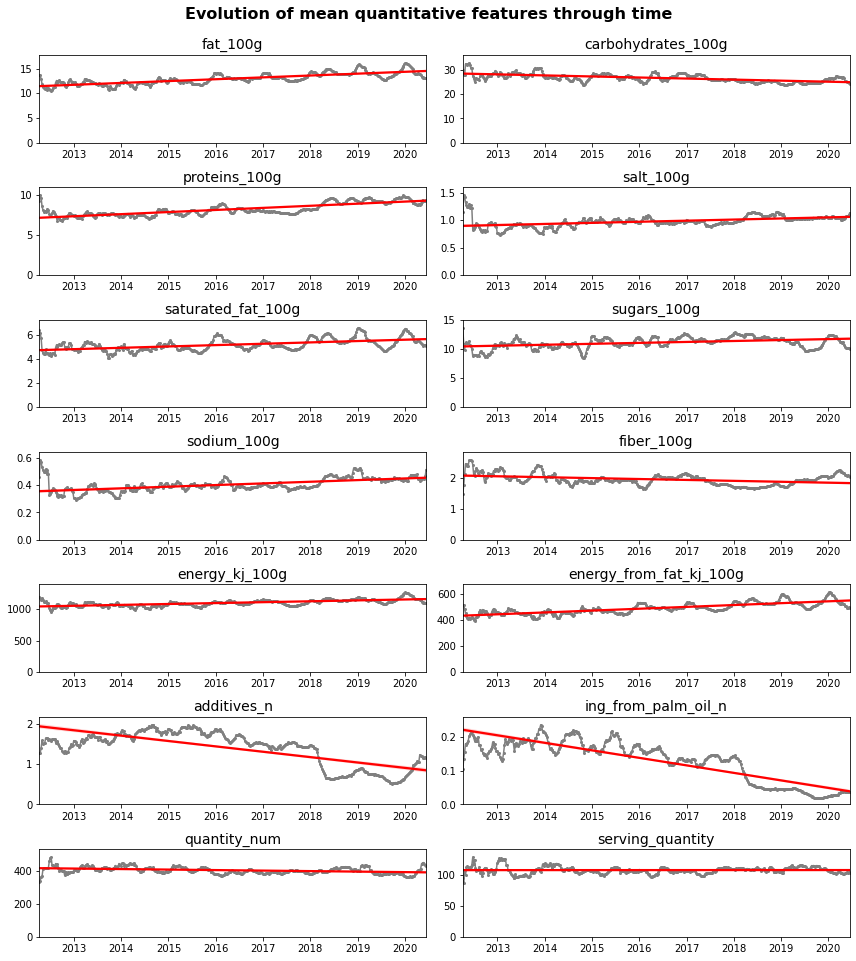

In [38]:
# Plotting evolution of the mean of main quantitative features
# in newly entered items through time (aggregated on weeks )

col_100g = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g',
            'saturated_fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g',
            'energy_kj_100g', 'energy_from_fat_kj_100g', 'additives_n', 'ing_from_palm_oil_n',
            'quantity_num', 'serving_quantity']
df_100g_thr_time = df.set_index('created_datetime').sort_index()[col_100g]
df_100g_thr_time = df_100g_thr_time.resample('W').mean()
dates = mdates.date2num(df_100g_thr_time.index)

fig = plt.figure(figsize=(12,14))

for i, c in enumerate(col_100g,1):
    ax = fig.add_subplot(7,2,i)
    y_roll = df_100g_thr_time[c].fillna(df_100g_thr_time[c].median()).rolling(10).mean().values
    plt.plot_date(dates, y_roll, ls='-', markersize=2, lw=1.5, color='grey')
    sns.regplot(dates, y_roll, marker='None', color='r', ax= ax)
    ax.set(ylim=(0,np.nanmax(y_roll)*1.1))
    ax.set_title(c, fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
fig.suptitle("Evolution of mean quantitative features through time",
             fontweight='bold', fontsize=16)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_2_2_evolution_100g.png',
                             dpi=400);
plt.show()

From these graphs we can hypothesize that the mean number of additives and of ingredients from palm oil is decreasing, especially since 2018.

Let's test these hypotheses.

In [39]:
# Regression coefficients and result of stationary tests on values per 100g

reg_df_100g_thr_time = mult_reg_thr_time(df_100g_thr_time)
reg_df_100g_thr_time = mult_test(data_df=df_100g_thr_time, res_df=reg_df_100g_thr_time,
                                 test_func='stat', print_opt=False)
display(reg_df_100g_thr_time)
# display(reg_df_100g_thr_time[['energy_kj_100g','ing_from_palm_oil_n', 'additives_n', 'quantity_num']])

fat_100g  ...  serving_quantity
coef                     0.000991345  ...       0.000359794
intercept                    11.4704  ...           106.646
mean                         12.9935  ...           107.199
Kwiatkowski           (0.01, 'True')  ...    (0.1, 'False')
Aug. Dickey-Fuller  (0.0032, 'True')  ...  (0.0003, 'True')

[5 rows x 14 columns]

In [40]:
mult_test(data_df=df_100g_thr_time, res_df=reg_df_100g_thr_time,
                                 test_func='stat', print_opt=True)

oooo--fat_100g--oooo
--- Kwiatkowski---
stat=2.369, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -3.774959
p-value: 0.003174
prob. stationary

oooo--carbohydrates_100g--oooo
--- Kwiatkowski---
stat=2.288, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -3.218653
p-value: 0.018930
prob. stationary

oooo--proteins_100g--oooo
--- Kwiatkowski---
stat=2.702, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -1.252755
p-value: 0.650500
prob. not stationary

oooo--salt_100g--oooo
--- Kwiatkowski---
stat=1.212, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -5.671247
p-value: 0.000001
prob. stationary

oooo--saturated_fat_100g--oooo
--- Kwiatkowski---
stat=0.996, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -4.806377
p-value: 0.000053
prob. stationary

oooo--sugars_100g--oooo
--- Kwiatkowski---
stat=0.489, p=0.044
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -7.006590
p-value: 0.000000
p

fat_100g  ...  serving_quantity
coef                     0.000991345  ...       0.000359794
intercept                    11.4704  ...           106.646
mean                         12.9935  ...           107.199
Kwiatkowski           (0.01, 'True')  ...    (0.1, 'False')
Aug. Dickey-Fuller  (0.0032, 'True')  ...  (0.0003, 'True')

[5 rows x 14 columns]

Indeed, according to both 'Kwiatkowski' and 'Augmented Dickey-Fuller' tests indicate that ingredients from palm oil an additives number are not stationary. The decrease we see is indeed statistically significant.

Fats, salt and proteins seem to slowly increase in newly entered 

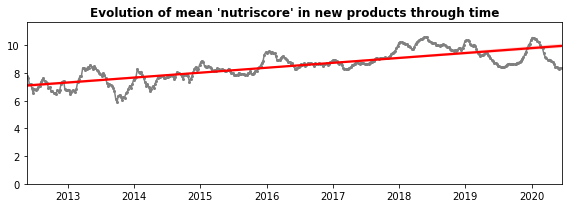

--- Kwiatkowski---
stat=2.433, p=0.010
prob. trend-stationary
--- Aug. Dickey-Fuller ---
 stat.: -1.838192
p-value: 0.361672
prob. not stationary



In [41]:
# Plotting evolution of main quantitative features through time

ser_nut = df.set_index('created_datetime').sort_index()['nutriscore']
ser_nut = ser_nut.resample('W').mean()
dates = mdates.date2num(df_100g_thr_time.index)

fig = plt.figure(figsize=(8,3))
y_roll = ser_nut.rolling(10).mean().values
plt.plot_date(dates, y_roll, ls='-', markersize=2, lw=1.5, color='grey')
ax = plt.gca()
sns.regplot(dates, y_roll, marker='None', color='r', ax= ax)
ax.set(ylim=(0,np.nanmax(y_roll)*1.1))
ax.set_title("Evolution of mean 'nutriscore' in new products through time",
             fontweight='bold')
fig.tight_layout()
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_2_2_evol_nutriscore.png',
                             dpi=400);
plt.show()

# Regression coefficients and result of stationary tests on 'nutriscore'

stationary_tests(y_roll, print_opt=True);

The stationary tests are unanimous, the mean value of nutriscore in new items tends to increase (to lesser healthy food) with time.

## 3 Bivariate analysis

### 3.1 Quantitative vs. categorical data

#### nutrigrade and main nutritional components

We would like to know which nutritional components have more influence on the nutrigrade of a product. Let's plot boxplots for each quantitative feature for each nutrigrade.

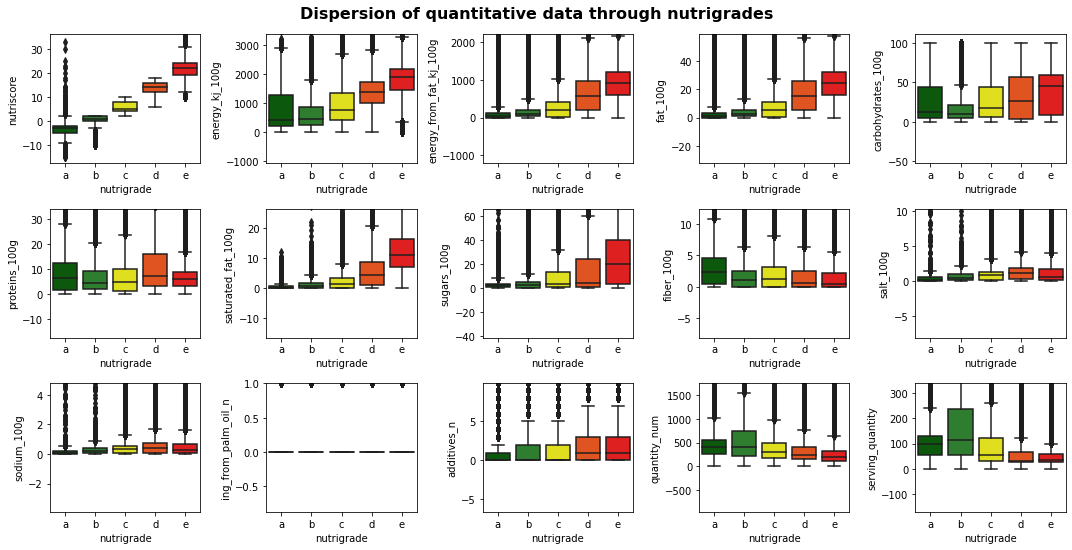

In [42]:
# Plotting boxplot of quantitative features for each nutrigrade

# nutri_pal = ['darkgreen', 'forestgreen', 'yellow', 'orangered', 'red']

fig = plt.figure(figsize=(15,8))
with sns.color_palette(nutri_pal):
    for i, c in enumerate(quant_cols,1):
        ax = fig.add_subplot(3,5,i)
        sns.boxplot(data=df, x='nutrigrade', y=c, order=list('abcde'), ax=ax)
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Dispersion of quantitative data through nutrigrades', fontsize=16,
             fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_nutrigrade_boxplots.png',
                             dpi=400);
plt.show()

Some features show very different distributions against nutrigrade. Except nutriscore which is at the root of nutrigrade ranking, we notice that fat, saturated fat and energy (and thus energy from fat) show the most different distributions along nutrigrade.

To a lesser extend, sugar, carbohudrates, sodium/salt and fiber also show different distributions.

The quantity of the product ('quantity_num') and the size of a portion ('serving_quantity') also seem to decrease when nutrigrade go from A to E.

Let's have a closer look on the distributions of energy for each nutrigrade.

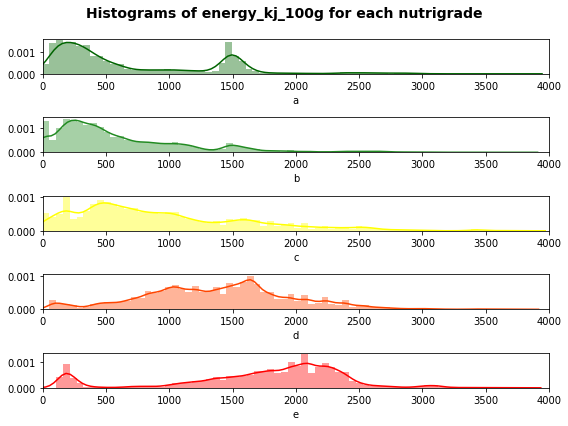

In [43]:
# Selecting the nutriscore series of pnns2 categories to compare

gb = df.groupby('nutrigrade')['energy_kj_100g']
nutrigr_df = pd.DataFrame([gb.get_group(n).values for n in list('abcde')],
                            index = list('abcde')).T

# Plotting histogram for each category

fig = plt.figure(figsize=(8,6))

i=0
for n, c in zip(list('abcde'), nutri_pal):
    i+=1
    ax = fig.add_subplot(5,1,i)
    sns.distplot(nutrigr_df[n], color=c, bins=70)
    ax.set(xlim=(0,4000))
fig.suptitle('Histograms of energy_kj_100g for each nutrigrade',
             fontweight='bold', fontsize=14)
plt.tight_layout(rect=[0,0.0,1,0.93])
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_nutrigrade_energy.png',
                             dpi=400);
plt.show()

The following statements can be made from these histograms:
- the distributions globally shift towards higher values from A to E
- A and E categories have bimodal distributions: some A products have high energy and E products have low energy.

Let's see which are these products:
- with A nutrigrade and high energy
- with E nutriscore and low energy

product_name  ...    pnns2
91671                            Slivered blanched almonds  ...   cheese
1066638                                   Makaron świderki  ...  cereals
1177613                                           Paccheri  ...  cereals
894461                                     Chia-Samen ganz  ...   cheese
47390    American beauty, enriched macaroni product, sm...  ...  cereals

[5 rows x 3 columns]


3 more represented pnns2 groups:  Index(['cereals', 'breakfast cereals', 'cheese'], dtype='object') 



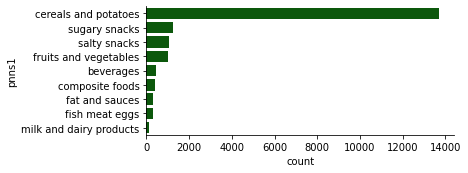

In [44]:
# Plotting a sample of A products with high energy and
# determining the pnns corresponding categories of food

cond1 = df['nutrigrade']=='a'
cond2 = df['energy_kj_100g'].between(1450,4000)
A_high_en_df = df.loc[cond1&cond2, ['product_name', 'pnns1', 'pnns2']]
display(A_high_en_df.sample(5))
vc1 = A_high_en_df['pnns1'].value_counts()
vc2 = A_high_en_df['pnns2'].value_counts()

print("\n3 more represented pnns2 groups: ", vc2.index[0:3],'\n' )

sns.catplot(y="pnns1", kind="count", color='darkgreen', data=A_high_en_df,
            orient='h', order=vc1.index)
plt.gcf().set_size_inches(8,2)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_high_energy_A.png',
                             dpi=400);
plt.show()

We can see here that, indeed, cerals and nuts, as they are very dense food, have a high energy rate but a low nutrigrade.

product_name  ... sugars_100g
193585                    Aloe vera drink  ...        8.80
644211  Sirop De Fraise Au Sucre De Canne  ...       10.00
372191              Lumi, Big Green Juice  ...        7.00
672710                     Nectar abricot  ...       13.00
152151            Creamy strawberry shake  ...        1.69

[5 rows x 4 columns]


3 more represented pnns2 groups:  Index(['sweetened beverages', 'unsweetened beverages', 'fruit nectars'], dtype='object') 



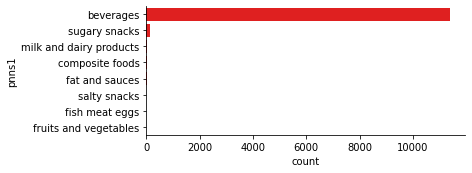

In [45]:
# Plotting a sample of E products with low energy and
# determining the pnns corresponding categories of food

cond1 = df['nutrigrade']=='e'
cond2 = df['energy_kj_100g'].between(0,500)
A_high_en_df = df.loc[cond1&cond2, ['product_name', 'pnns1', 'pnns2','sugars_100g']]
display(A_high_en_df.sample(5))
vc1 = A_high_en_df['pnns1'].value_counts()
vc2 = A_high_en_df['pnns2'].value_counts()

print("\n3 more represented pnns2 groups: ", vc2.index[0:3],'\n' )

sns.catplot(y="pnns1", kind="count", color='red', data=A_high_en_df,
            orient='h', order=vc1.index)
plt.gcf().set_size_inches(8,2)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_low_energy_E.png',
                             dpi=400);
plt.show()

Almost all the products with high nutriscore and low energy content are beverages with high sugar content.

The above results indicate that the categories of food are very informative and should be taken into account in search for healty food.

#### Food categories and nutriscore

Let's have a look on the dispersion of quantitative values for the main categories of food. We'll use pnns1 categories at first.

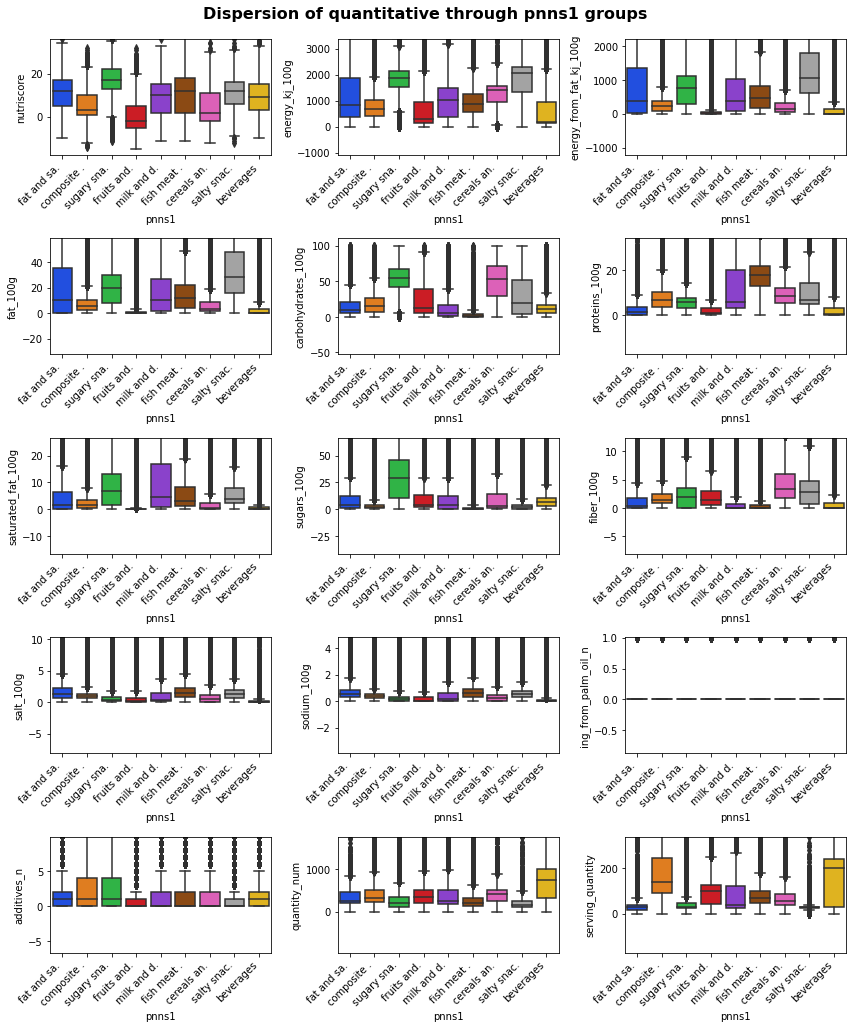

In [46]:
# Plotting boxplots of each quantitative data for each pnns1 categories 

pnns1_pal = sns.color_palette(palette='bright')

fig = plt.figure(figsize=(12,15))
with sns.color_palette(pnns1_pal):
    for i, c in enumerate(quant_cols,1):
        ax = fig.add_subplot(5,3,i)
        sns.boxplot(data=df, x='pnns1', y=c, ax=ax)# order=list('abcde')
        min = df[c].mean()-3*df[c].std()
        max = df[c].mean()+3*df[c].std()
        plt.ylim(min,max)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[0:10]+'.' if len(s)>10 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('Dispersion of quantitative through pnns1 groups', fontsize=16,
             fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_pnns1_boxplots.png',
                             dpi=400);
plt.show()

According to these boxplots, we can hypothesize that pnns1 categories are not homogeneous through any quantitative value.

Let's plot the mean values for 'nutriscore' for each 'pnns1' categories.

In [47]:
df.groupby(['pnns1'])['nutriscore'].agg([np.median, np.mean, np.std]).T

pnns1   beverages  cereals and potatoes  ...  salty snacks  sugary snacks
median   9.000000              2.000000  ...     12.000000      17.000000
mean     9.413180              3.946741  ...     11.148504      16.551996
std      7.658031              7.564593  ...      7.214078       7.359638

[3 rows x 9 columns]

The means, as well as the standard deviations look different, but, lets' check if these discrepancies in the mean values are statistically significant.

We know that the data are not normally distributed, we should therefore not use ANOVA, as it requires normally distributed data. We will use the Kruskal-Wallis H Test (non-parametric) that only requires iid data, and print ANOVA result for information purpose only.

In [48]:
# Printing results of ANOVA and Kruskal-Wallis tests for 'nutriscore' vs. 'pnns1'

id_cat_distrib_tests(df[quant_cols+['pnns1']], C_col='pnns1',
                     Q_col='nutriscore', print_opt=True)

oooooooo- nutriscore vs. pnns1 -oooooooo
---ANOVA---
stat=31351.563, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=170434.592, p=0.0000000000
Prob. different distr


{'ANOVA': (0.0, 'False'), 'Kruskal-Wallis': (0.0, 'False')}

At least one of the categorical distributions (pnns1 groups) of nutriscore is significantly different from the others.

Let's see now is there is one or more quantitative features that have the sem distributions for all the pnns1 categories:

In [49]:
# Results (p-value, same distr or not) of ANOVA and Kruskal-Wallis tests
# for 'nutriscore' vs. 'pnns1' categories

id_distr_pnns1 = mult_test(df[quant_cols+['pnns1']], C_col='pnns1',
                           test_func='id_dist', print_opt=False)
id_distr_pnns1

nutriscore  energy_kj_100g  ...    quantity_num serving_quantity
ANOVA           (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')
Kruskal-Wallis  (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')

[2 rows x 15 columns]

Both ANOVA and Kruskal-Wallis test indicate that the distributions of all quantitative values are different through pnns1 categories.

Let's have a look to nutriscore of food categories more in detail using pnns2 categories.

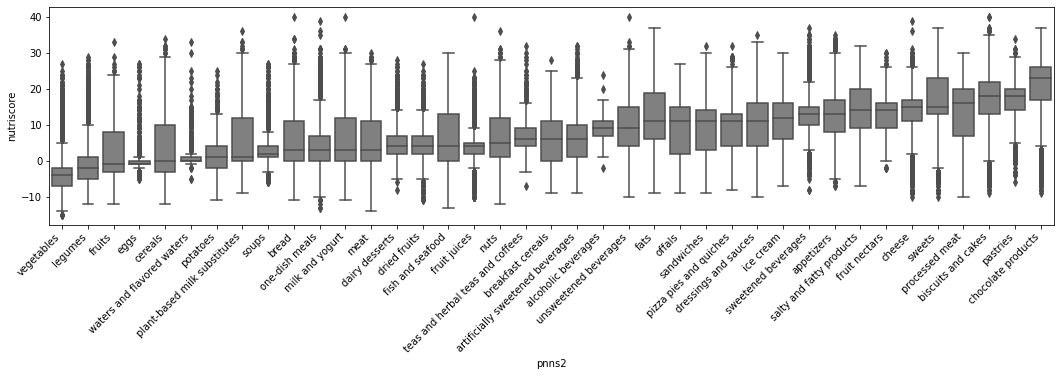

In [50]:
# Plotting distributions of nutriscore for each pnns2 category

sorted_ind = pd.DataFrame(df.groupby(['pnns2'])['nutriscore'].median())\
                                             .sort_values('nutriscore').index

sns.boxplot(data=df, x='pnns2', y='nutriscore', color='grey', order=sorted_ind)
plt.gcf().set_size_inches(18,4)
plt.xticks(rotation=45, ha='right');
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_pnns2_nutriscore.png',
                             dpi=400);
plt.show()

Among all the categories, the categories 'bread', 'dairy dessert', 'one-dish meals', 'fish and seafood' and 'meat' have a very close median.

mean  quant_0_25  median  quant_0_75       std
pnns2                                                               
bread             5.411788         0.0     3.0        11.0  7.215506
dairy desserts    5.326395         2.0     4.0         7.0  5.490773
one-dish meals    4.501534         0.0     3.0         7.0  6.283396
fish and seafood  6.260082         0.0     4.0        13.0  7.369080
meat              4.805458         0.0     3.0        11.0  7.003047

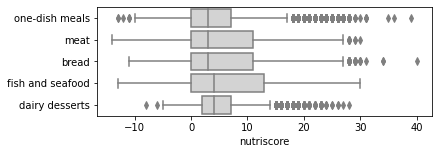

In [51]:
# Printing the main statistical indicators 

sim_pnns2_groups = ['bread', 'dairy desserts', 'one-dish meals',
                  'fish and seafood', 'meat']
df_ = df[df['pnns2'].isin(sim_pnns2_groups)][quant_cols+['pnns2']]

def quant_0_25(x): return np.quantile(x,q=0.25)
def quant_0_75(x): return np.quantile(x,q=0.75)

display(df.groupby('pnns2')['nutriscore'].agg(['mean', quant_0_25, np.median,
                                       quant_0_75, np.std]).loc[sim_pnns2_groups])

# Plotting boxplots of nutriscores of selected pnns2

sns.boxplot(data=df_, y='pnns2', x='nutriscore', color='lightgrey', orient='h')
plt.gcf().set_size_inches(6,2), plt.ylabel('');
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_pnns2_compar_box.png',
                             dpi=400);
plt.show()

Lets' see in more detail if the distribution of their nutriscore are really similar.

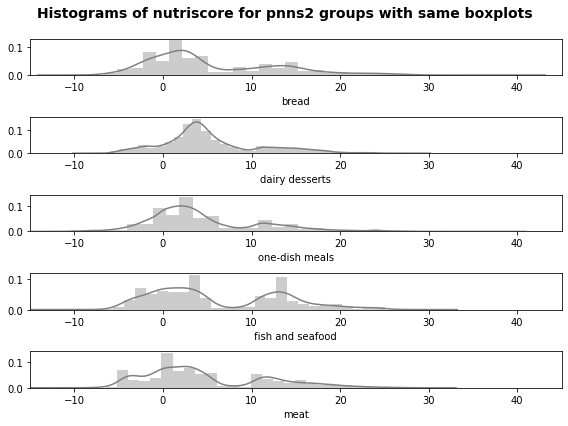

In [52]:
# Selecting the nutriscore series of pnns2 categories to compare

gb = df.groupby('pnns2')['nutriscore']
sim_gr_nutri = pd.DataFrame([gb.get_group(n).values for n in sim_pnns2_groups],
                            index = sim_pnns2_groups).T

# Plotting histogram for each category

fig = plt.figure(figsize=(8,6))
for i, c in enumerate(sim_pnns2_groups,1):
    ax = fig.add_subplot(5,1,i)
    # plt.hist(sim_gr_nutri[c], color='b', bins=35)
    sns.distplot(sim_gr_nutri[c], color='grey', bins=35)
    ax.set(xlim=(-15,45))
fig.suptitle('Histograms of nutriscore for pnns2 groups with same boxplots',
             fontweight='bold', fontsize=14)
plt.tight_layout(rect=[0,0.0,1,0.93])
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_pnns2_compar_hist.png',
                             dpi=400);
plt.show()

Indeed, some distributions look very similar. Let's see if ANOVA and Kruskal-Wallis tests validate this intuition.

In [53]:
# Results (p-value, same distr or not) of ANOVA and Kruskal-Wallis tests
# for 'nutriscore' vs. chosen 'pnns2' categories

id_distr_pnns2_sel = mult_test(df_, C_col='pnns2',test_func='id_dist',
                               print_opt=False)
id_distr_pnns2_sel

nutriscore  energy_kj_100g  ...    quantity_num serving_quantity
ANOVA           (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')
Kruskal-Wallis  (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')

[2 rows x 15 columns]

Contrary to the intuition, the tests indicate that the distribution of none of the quantitative variables of the five chosen categories can be considered all similar.

Let's see if at least two of the categories among the five have the same distribution:

In [54]:
# Printing the result of ANOVA and Kruskal test for all combination
# of 2 groups in the selected pnns2 groups

tab = []
for c1 in sim_pnns2_groups:
    for c2 in [c for c in sim_pnns2_groups if c!=c1]:
        couple = [c1,c2]
        if [c2,c1] not in tab:
            print('\nXXXXXXX---',str(couple).upper(), '---XXXXXXX')
            df__ = df[df['pnns2'].isin(couple)][quant_cols+['pnns2']]
            id_cat_distrib_tests(df__, Q_col='nutriscore', C_col='pnns2', print_opt=True)
            tab.append(couple)


XXXXXXX--- ['BREAD', 'DAIRY DESSERTS'] ---XXXXXXX
oooooooo- nutriscore vs. pnns2 -oooooooo
---ANOVA---
stat=0.560, p=0.4541503581
Prob. same distr
---Kruskal-Wallis---
stat=94.353, p=0.0000000000
Prob. different distr

XXXXXXX--- ['BREAD', 'ONE-DISH MEALS'] ---XXXXXXX
oooooooo- nutriscore vs. pnns2 -oooooooo
---ANOVA---
stat=254.590, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=60.845, p=0.0000000000
Prob. different distr

XXXXXXX--- ['BREAD', 'FISH AND SEAFOOD'] ---XXXXXXX
oooooooo- nutriscore vs. pnns2 -oooooooo
---ANOVA---
stat=137.337, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=117.391, p=0.0000000000
Prob. different distr

XXXXXXX--- ['BREAD', 'MEAT'] ---XXXXXXX
oooooooo- nutriscore vs. pnns2 -oooooooo
---ANOVA---
stat=73.108, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=60.376, p=0.0000000000
Prob. different distr

XXXXXXX--- ['DAIRY DESSERTS', 'ONE-DISH MEALS'] ---XXXXXXX
oooooooo- nutriscore vs. pnns2 -oooooooo
---ANOVA--

According to ANOVA, 'fish and seafood' and 'meat' is the only couple that may have similar  distribution of nutriscores, whereas Kruskal-WAllis test states that 'one-dish meal' and 'fish and seafood' categories may have the same distributions.

The bimodal distribution of both 'fish and seafood' and 'meat' is quite surprising and reinforce the idea that these two categories may bethe same.

Lets's plot the distribution of the others quantitative data for 'fish and seafood' and 'meat' through a violin plots:

In [55]:
# Selecting a subset dataframe with only 'fish and seafood' and 'meat'

df_ = df[df['pnns2'].isin(['fish and seafood', 'meat'])][quant_cols+['pnns2']]
df_.sample(3)

nutriscore  energy_kj_100g  ...  serving_quantity             pnns2
209565         15.0          1025.0  ...             151.0              meat
213394         -5.0           531.0  ...              79.0              meat
1336445         0.0           335.0  ...               NaN  fish and seafood

[3 rows x 16 columns]

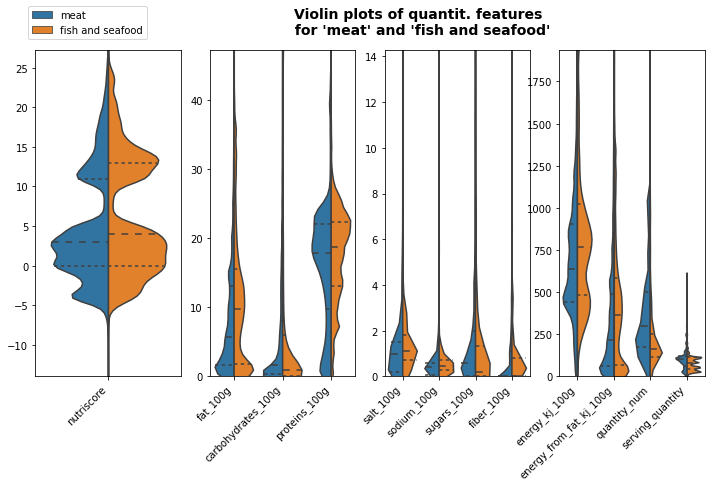

In [56]:
# Plotting the distributions of other quantitative features
# for 'meat' and 'fish and seafood' 

fig = plt.figure(figsize=(12,6))

cols0 = ['nutriscore']
cols1 = ['fat_100g', 'carbohydrates_100g', 'proteins_100g']
cols2 = ['salt_100g', 'sodium_100g', 'sugars_100g', 'fiber_100g']
cols3 = ['energy_kj_100g', 'energy_from_fat_kj_100g', 'quantity_num', 'serving_quantity']
cols4 = ['ing_from_palm_oil_n', 'additives_n']

for i, c_sel in enumerate([cols0, cols1, cols2, cols3],1):
    df__ = df_[c_sel+['pnns2']]
    df__ = df__.melt(id_vars=['pnns2'] , var_name='quant_var',
                    value_vars=c_sel, value_name='value_100g' )
    ax = fig.add_subplot(1,4,i)
    sns.violinplot(data=df__, y='value_100g', x='quant_var', inner='quartile',
                hue='pnns2', split=True, scale='count',  bw=0.1, orient='v', ax=ax)

    v_min = df__['value_100g'].min()
    v_max = df__['value_100g'].mean()+3*df__['value_100g'].std()
    
    plt.gca().set(ylim=(v_min, v_max))
    plt.xticks(rotation=45, ha='right')
    ax.get_legend().remove()
    plt.ylabel(''), plt.xlabel('')
plt.legend(bbox_to_anchor=(-2.8,1.15))

fig.suptitle("                        Violin plots of quantit. features\n         \
                 for 'meat' and 'fish and seafood'",
             fontweight='bold', fontsize=14)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_meat_fish_violin.png',
                             dpi=400);
plt.tight_layout(rect=[0,0.5,1,0.95], w_pad=0.5)

We see from this violin plot that the distributions of the other quantitative features are quite similar.

In [57]:
# ANOVA and Kruskal-Wallis testing

id_distr_pnns2_sel = mult_test(df_, C_col='pnns2',test_func='id_dist',
                               print_opt=False)
id_distr_pnns2_sel

nutriscore  energy_kj_100g  ...    quantity_num serving_quantity
ANOVA           (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')
Kruskal-Wallis  (0.0, 'False')  (0.0, 'False')  ...  (0.0, 'False')   (0.0, 'False')

[2 rows x 15 columns]

However, the statistical test does not shows that, apart from nutriscore, the distributions are the same.

#### Brands and nutriscore

Is this possible to identify generalist brands that would always offer better nutriscore-ranked products for all categories ?

We'll make a selection of well-enough represented brands and pnns2 categories to try to answer this question (30 products per category and brand combination).

In [58]:
# Selecting the main pnns2 categories on which we want to compare brands

set_cat = set(['dressings and sauces', 'one-dish meals', 'biscuits and cakes',
       'fruits', 'cheese', 'meat', 'bread', 'fish and seafood',
       'vegetables', 'salty and fatty products', 'fruit juices', 'sweets',
       'dairy desserts', 'pastries', 'pizza pies and quiches',
       'soups', 'cereals', 'appetizers', 'sandwiches', 'fats',
       'chocolate products', 'processed meat', 'milk and yogurt',
       'breakfast cereals', 'potatoes', 'ice cream','offals', 'fruit nectars'])

# -- Getting the brands that makes the 3 categories of food
set_brands = set(df['brands_main'].unique())
for cat in set_cat:
    df_ = df[df['pnns2']==cat][quant_cols+['brands_main']]
    set_brands = set_brands & set(df_['brands_main'].unique())  
set_brands = {s for s in set_brands\
                 if s==s and s!='sans marque'}

# -- Creating the subset dataframe
cond1 = df['brands_main'].isin(set_brands)
cond2 = df['pnns2'].isin(set_cat)
df_ = df.loc[cond1&cond2]
data_crosstab = pd.crosstab(df_['pnns2'], df_['brands_main'], margins = True)

# -- Selecting brands and categ with more than 350 products
cond_brands = data_crosstab.loc['All',:]>1000
set_brands = set(data_crosstab.loc[:,cond_brands].columns)-set(['All'])
cond_cats = data_crosstab.loc[:,'All']>1000
set_cats = set(data_crosstab.loc[cond_cats].index)-set(['All'])
cond1 = df['brands_main'].isin(set_brands)
cond2 = df['pnns2'].isin(set_cats)
df_ = df.loc[cond1&cond2]

print('number of brands to be compared: ', len(set_brands))
for i, b in enumerate(set_brands):
    print('\n'+b if i % 7 == 0 else b, end=' | ')

print('\n\nnumber of pnns2 categories: ', len(set_cats))
for i, c in enumerate(set_cats):
    print('\n'+c if i % 5 == 0 else c, end=' | ')

number of brands to be compared:  13

monoprix | auchan | leader price | dia | migros | hacendado | u | 
casino | carrefour | delhaize | belle france | netto | cora | 

number of pnns2 categories:  14

sweets | one-dish meals | dressings and sauces | meat | cheese | 
bread | milk and yogurt | appetizers | vegetables | cereals | 
fruits | biscuits and cakes | processed meat | fish and seafood | 

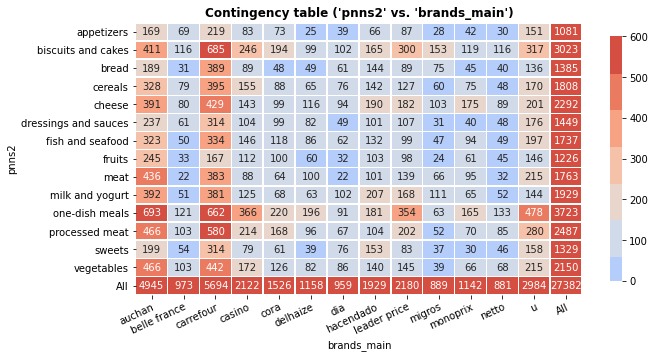

In [59]:
# Plotting table of contingency

data_crosstab = pd.crosstab(df_['pnns2'], df_['brands_main'], margins = True)
plot_heatmap(data_crosstab,"Contingency table ('pnns2' vs. 'brands_main')",
             vmin=0, center= 150, vmax=600, fmt='.0f',
             palette=sns.color_palette("coolwarm", 10),figsize=(10,5),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_brands_pnns2_pop.png',
                             dpi=400);
plt.show()

The contingency table above show that we have enough data to compare all the selected brands on all the selected categories.

Let's establish a ranking of brands based on the mean nutriscore 

In [60]:
## Nutriscore ranking the brands for each pnns2 category

# -- Mean nutriscore for each brand and each category
df_nutri_mean, df_nutri_median = pd.DataFrame([]), pd.DataFrame([])
for c in set_cat:
    for b in set_brands:
        c1 = df['brands_main']==b
        c2 = df['pnns2']==c
        df_nutri_mean.loc[b,c] = df[c1&c2]['nutriscore'].mean()
        df_nutri_median.loc[b,c] = df[c1&c2]['nutriscore'].median()

# -- Rank of each brand for each prodcut
df_rank_mean, df_rank_median = pd.DataFrame([]), pd.DataFrame([])
df_rank_mean = df_nutri_mean.apply(rankdata,axis=0)
df_rank_median = df_nutri_median.apply(rankdata,axis=0)

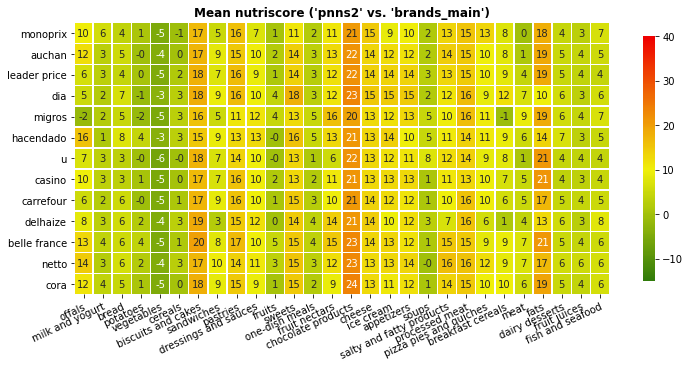

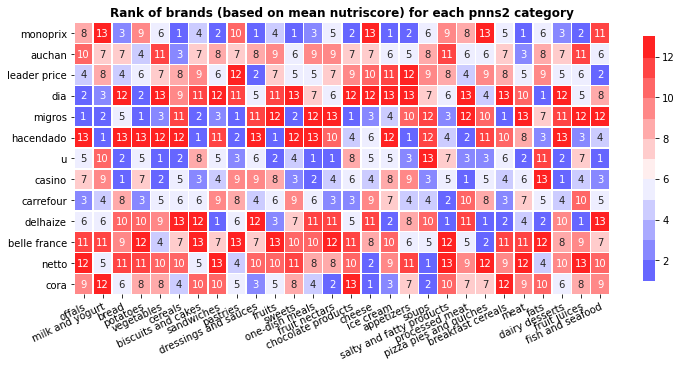

In [61]:
# -- Plotting heatmaps of mean nutriscore for each brand and pnns2 catagory

N = 128
vals = np.ones((2*N, 4))
vals[:, 0] = np.concatenate((np.linspace(5/N, 120/N, N), np.linspace(120/N, 120/N, N)))
vals[:, 1] = np.concatenate((np.linspace(50/N, 120/N,  N), np.linspace(120/N, 0/N, N)))
vals[:, 2] = np.concatenate((np.linspace(5/N, 5/N, N), np.linspace(5/N, 0/N, N)))
Green2Red = ListedColormap(vals)

plot_heatmap(df_nutri_mean,"Mean nutriscore ('pnns2' vs. 'brands_main')",
             vmin=-15, center= 10, vmax=40, fmt='.0f',
             palette=Green2Red,#sns.color_palette("viridis", 10),
             figsize=(12,5),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_brands_mean_nutri.png',
                             dpi=400);
plt.show()
plot_heatmap(df_rank_mean,
             "Rank of brands (based on mean nutriscore) for each pnns2 category",
             vmin=1, center=6, vmax=13, fmt='.0f',
             palette=sns.color_palette("bwr", 14),
             figsize=(12,5),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_brands_ranking_table.png',
                             dpi=400);
plt.show()

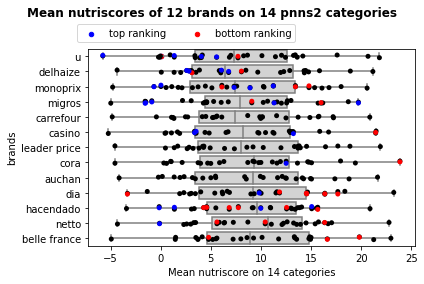

In [62]:
# Showing the ranking of brands for mean nutriscores on pnns2 categories

# -- Preparing unstacked dataframes for easier plotting with seaborn
df_ = df_nutri_mean.T.reset_index().rename(columns={'index':'pnns2'})
df_ = df_.melt(id_vars=['pnns2'] , var_name='brand',
                    value_vars=df_nutri_mean.index, value_name='nutri_mean' )
ordered_brands = df_nutri_mean.mean(axis=1).sort_values().index
df_bottom_ = df_nutri_mean.where(df_nutri_mean==df_nutri_mean.max(axis=0))
df_bottom_ = df_bottom_.T.reset_index().rename(columns={'index':'pnns2'})
df_bottom_ = df_bottom_.melt(id_vars=['pnns2'] , var_name='brand',
                    value_vars=df_nutri_mean.index, value_name='nutri_mean')

df_top_ = df_nutri_mean.where(df_nutri_mean==df_nutri_mean.min(axis=0))
df_top_ = df_top_.T.reset_index().rename(columns={'index':'pnns2'})
df_top_ = df_top_.melt(id_vars=['pnns2'] , var_name='brand',
                    value_vars=df_nutri_mean.index, value_name='nutri_mean' )

# -- Plotting boxplots, stripplots of mean nutriscores and first, last rankings
fig = plt.figure(figsize=(6,4))
sns.boxplot(y='brand' , x='nutri_mean', color='lightgrey',
            data = df_, order = ordered_brands)
sns.stripplot(y='brand' , x='nutri_mean', color='k',
              data = df_, order = ordered_brands)
sns.stripplot(y='brand' , x='nutri_mean', color='r',
              data = df_bottom_, order = ordered_brands)
sns.stripplot(y='brand' , x='nutri_mean', color='b',
              data = df_top_, order = ordered_brands)
ax = plt.gca()
ax.scatter([0],[0], c='b', s=20, label='top ranking')
ax.scatter([0],[0], c='r', s=20, label='bottom ranking')
plt.tight_layout(rect=[0,0,1,0.87])
plt.suptitle('Mean nutriscores of 12 brands on 14 pnns2 categories',
             fontweight='bold', fontsize=12)
ax.set_xlabel('Mean nutriscore on 14 categories'), ax.set_ylabel('brands')
ax.legend(bbox_to_anchor=(0.65,1.15), ncol=2)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_brands_ranking.png',
                             dpi=400);
plt.show()

In [63]:
# First and last rankings for each brand

df_res = pd.DataFrame([])
df_res['top rank brand'] = df_rank_mean.idxmin(axis=0)
df_res['bottom rank brand'] = df_rank_mean.idxmax(axis=0)

print('--- BETTER RANKING ---')
print(df_res['top rank brand'].value_counts())
print("---- Lists of first ranking -----")
[print(b +': '+ str(list(df_res[df_res['top rank brand']==b].index)))\
                              for b in set(df_res['top rank brand'])];
print('--- WORST RANKING ---')
print(df_res['bottom rank brand'].value_counts())
print("\n---- Lists of last ranking -----")
[print(b +': '+ str(list(df_res[df_res['bottom rank brand']==b].index)))\
                              for b in set(df_res['bottom rank brand'])];

--- BETTER RANKING ---
migros       5
monoprix     5
u            4
hacendado    4
delhaize     4
casino       3
cora         1
netto        1
dia          1
Name: top rank brand, dtype: int64
---- Lists of first ranking -----
monoprix: ['cereals', 'dressings and sauces', 'sweets', 'ice cream', 'meat']
migros: ['offals', 'potatoes', 'pastries', 'chocolate products', 'breakfast cereals']
dia: ['fats']
hacendado: ['milk and yogurt', 'biscuits and cakes', 'fruits', 'appetizers']
u: ['vegetables', 'one-dish meals', 'fruit nectars', 'fish and seafood']
casino: ['bread', 'processed meat', 'dairy desserts']
delhaize: ['sandwiches', 'salty and fatty products', 'pizza pies and quiches', 'fruit juices']
netto: ['soups']
cora: ['cheese']
--- WORST RANKING ---
hacendado       6
dia             6
netto           3
belle france    3
monoprix        3
migros          2
delhaize        2
u               1
cora            1
casino          1
Name: bottom rank brand, dtype: int64

---- Lists of last ran

This graph and the data printed below show that some brands have indeed better mean nutriscores than others.
In particular we notice that:
- Monoprix, Delhaize and U have 6 better ranking
- Netto and Dia have 9 and 7 worst ranking
- Hacendado have 4 better and 4 worst ranking

### 3.2 Quantitative vs. quantitative data

#### Pair plots

Let's check at first that related features have the behaviour we expect: 

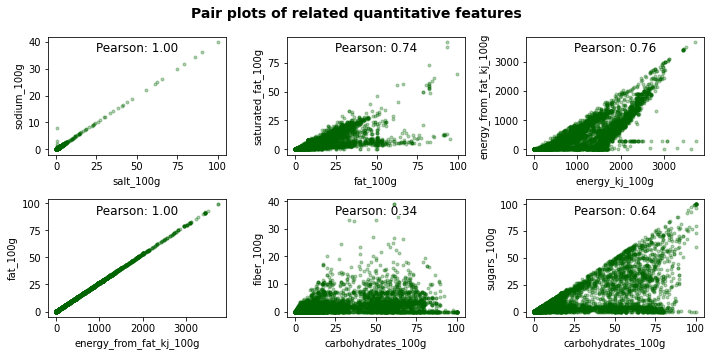

In [64]:
# Function to show scatter plot:

def pair_plot(df,c):
    x, y = c
    plt.scatter(df[x], df[y], marker='.', alpha=0.3, color = 'darkgreen')
    # plt.scatter(df[x], df[y], marker='o', edgecolors='darkblue',
    #             alpha=0.5, color='grey', s=20)
      
    plt.xlabel(x), plt.ylabel(y)
    plt.text(0.5, 0.9, 'Pearson: %.2f'%df[c].corr().iloc[0,1],
        ha='center', va='center', fontsize=12, c='k', transform=ax.transAxes)

dict_couples = {'c1': ['salt_100g', 'sodium_100g'],
                'c2': ['fat_100g', 'saturated_fat_100g'],
                'c3': ['energy_kj_100g', 'energy_from_fat_kj_100g'],
                'c4': ['energy_from_fat_kj_100g', 'fat_100g'],
                'c5': ['carbohydrates_100g', 'fiber_100g'],
                'c6': ['carbohydrates_100g', 'sugars_100g']}

# Plotting related features

fig = plt.figure(figsize=(10,5))
for i, c in enumerate(dict_couples.items(),1):
    ax = fig.add_subplot(2,3,i)
    pair_plot(df.sample(5000),c[1])
plt.tight_layout(rect=[0,0,1,0.93])
plt.suptitle('Pair plots of related quantitative features',
             fontweight='bold', fontsize=14)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_2_pairplots_related.png',
                             dpi=400);
plt.show()

As expected, sodium is correlated with salt and fat to energy from fat.

Saturated fat is always lower than fat and sugars and fiber are lower than carbohydrates, and energy from fat is lower than total energy.

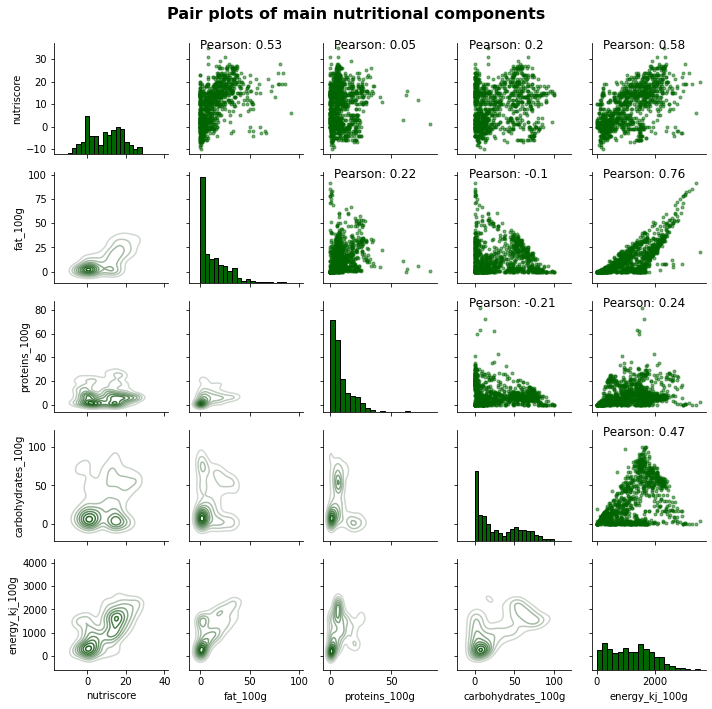

In [65]:
# Scatterplot matrix on main nutritional components (too much data -> on a sample)

# Creating grey to blue colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 5/N, N)
vals[:, 1] = np.linspace(0.9, 80/N,  N)
vals[:, 2] = np.linspace(0.9, 5/N, N)
Grey2Green = ListedColormap(vals)

# Function that prints Pearson correlation coefficient
def print_corr(x, y, **kwargs):
    label = r'Pearson: ' + str(round(np.corrcoef(x, y)[0][1], 2))
    ax = plt.gca()
    ax.annotate(label, xy = (0.1, 0.95), c='k', size = 12,
                xycoords = ax.transAxes)

cols = ['nutriscore', 'fat_100g', 'proteins_100g','carbohydrates_100g', 'energy_kj_100g']
df_sample = df.sample(1000)

# Creating the grid
grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2)

# Mapping the grid with plots and text
# grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkblue',
#                       alpha=0.5, color='blue', s=20)
grid = grid.map_upper(plt.scatter, marker='.', alpha=0.5, color = 'darkgreen')
grid = grid.map_upper(print_corr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkgreen', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = Grey2Green)

plt.tight_layout(rect=[0,0,1,0.95])
plt.suptitle('Pair plots of main nutritional components',
             fontweight='bold', fontsize=16)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_2_pairplots_grid.png',
                             dpi=400);
plt.show()

These pair plots show that:
- nutriscore increases with fat and then carbohydrates content
nutriscore increases with energy in general
- products with high content in fat tend to contain less carbohydrates and those which contain more carbohydrates tend to contain less fat.
- few products have high content in preteins
- energy tends to increase consistently with fat and carbohydrate contents, but proteins are less influential on the total energy content, probably because most of the of products contain less proteins than fats and carbohydrates.

#### Linear correlations



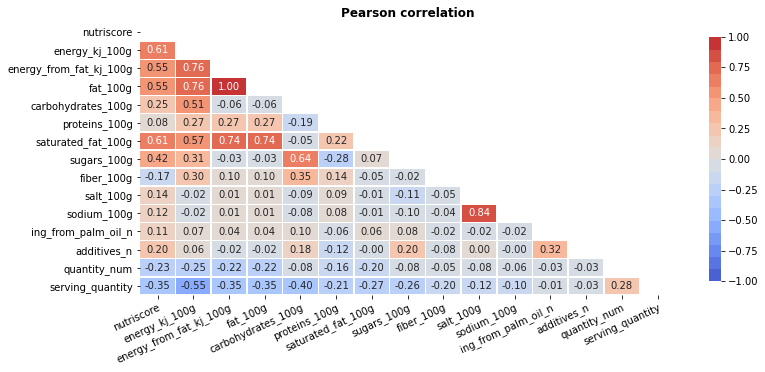

In [66]:
# Linear correlation (Pearson)

cols = quant_cols
pears_corr = df[cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(12,5))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_2_pearson_corr.png',
                             dpi=400);
plt.show()

As we've already seen above on pair plots, some of the correlations are quite obvious, as for example:
- fat -> energy
- sugars -> carbohydrates
- fat, saturated, fat, sugars, energy -> nutriscore
- nutriscore -> nutrigrade

But, more suprisingly :
- more fibers can be found in high energy products

As we know from its formula, nutriscore, not surprisingly:
- increases with energy, saturated fat, sugar and salt
- decreases with fibers, proteins and fruits and vegetable content

However, for most products, most nutriscore correlated factors are (in decreasing order of importance):
- energy, saturated fat, fat, carbohydrates, sugar (pearson coefficient >0.4)
- carbohydrates, salt and fiber are less influencial on nutriscore (abs(pearson coeff) < 0.25) 

__=> To get better nutrigrades, food industry should focus mainly on decreasing fat, sugar and global energy content of their products__.


We'll test for linear correlation (Pearson) and for monotonic relationship (Spearman, Kendall).

In [67]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlation_tests(data1, data2, print_opt=False):
    res_df = pd.DataFrame([])
    # data1_notna = data1[data1.notna()]
    # Pearson, Spearman, Kendall
    for f_name, func in zip(['Pearson', 'Spearman', 'Kendall'],[pearsonr, spearmanr, kendalltau]):
        stat, p = func(data1, data2)
        res_df.loc[f_name,'stat'] = stat
        res_df.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name)
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        if print_opt: print('Probably independent') if p > 0.05 else print('Probably dependent')
    return res_df

In [68]:
# Correlation test

test_couples = [('fat_100g','nutriscore'), ('carbohydrates_100g','nutriscore'),
                ('proteins_100g','nutriscore'), ('energy_kj_100g','nutriscore'),
                ('fiber_100g','nutriscore'), ('sugars_100g','nutriscore'),
                ('fat_100g','fiber_100g'), ('fat_100g','salt_100g'),
                ('ing_from_palm_oil_n','fiber_100g'), ('ing_from_palm_oil_n','salt_100g')]

df_ = df.sample(400000)
for tup in test_couples:
    print('------'+str(tup).upper()+'-----')
    c1, c2 = tup
    display(correlation_tests(df_[c1], df_[c2], print_opt=False))

------('FAT_100G', 'NUTRISCORE')-----


stat  p_value
Pearson   0.546270      0.0
Spearman  0.598898      0.0
Kendall   0.432869      0.0

------('CARBOHYDRATES_100G', 'NUTRISCORE')-----


stat  p_value
Pearson   0.251107      0.0
Spearman  0.201058      0.0
Kendall   0.141654      0.0

------('PROTEINS_100G', 'NUTRISCORE')-----


stat  p_value
Pearson   0.084032      0.0
Spearman  0.090915      0.0
Kendall   0.057687      0.0

------('ENERGY_KJ_100G', 'NUTRISCORE')-----


stat  p_value
Pearson   0.609760      0.0
Spearman  0.617868      0.0
Kendall   0.451217      0.0

------('FIBER_100G', 'NUTRISCORE')-----


stat  p_value
Pearson  -0.173070      0.0
Spearman -0.166785      0.0
Kendall  -0.118855      0.0

------('SUGARS_100G', 'NUTRISCORE')-----


stat  p_value
Pearson   0.423428      0.0
Spearman  0.332727      0.0
Kendall   0.234777      0.0

------('FAT_100G', 'FIBER_100G')-----


stat  p_value
Pearson   0.098634      0.0
Spearman  0.133982      0.0
Kendall   0.097202      0.0

------('FAT_100G', 'SALT_100G')-----


stat       p_value
Pearson   0.014954  3.132162e-21
Spearman  0.346281  0.000000e+00
Kendall   0.247128  0.000000e+00

------('ING_FROM_PALM_OIL_N', 'FIBER_100G')-----


stat       p_value
Pearson  -0.015302  3.726127e-22
Spearman  0.031771  7.598664e-90
Kendall   0.026984  5.556636e-90

------('ING_FROM_PALM_OIL_N', 'SALT_100G')-----


stat       p_value
Pearson  -0.016892  1.207650e-26
Spearman  0.013770  3.062343e-18
Kendall   0.011315  2.372688e-18

All 3 tests indicate a linear relationship with confidence level of 5% between the combination of features above listed. However we should temper these conclusions as this high sensitivity may be mainly due to the large amount of data available. If we submit a 1000 or 10 000 sample of the data to the same tests, conclusions are more conform to conclusions that can be easily drawn from pair plots.

#### Non-linear correlations

Now we'll test for non linear correlation using  Predictive Power Score (decision tree based).

We'll include quantitative and categorical features in our analysis.

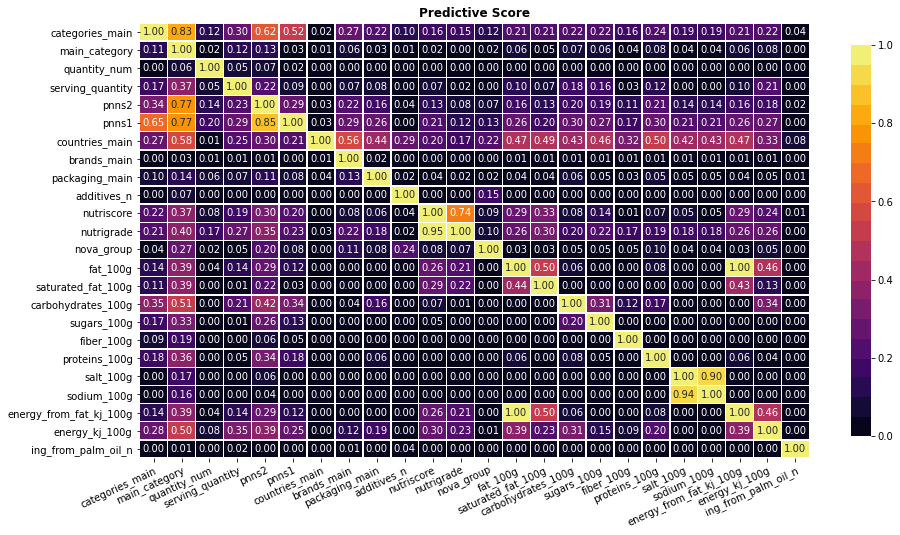

In [69]:
# Predictive Power Score on main features (ppscore)

cols = ['categories_main', 'main_category', 'quantity_num', 'serving_quantity',
'pnns2', 'pnns1', 'countries_main', 'brands_main', 'packaging_main', 
 'additives_n', 'nutriscore', 'nutrigrade', 'nova_group', 'fat_100g',
 'saturated_fat_100g', 'carbohydrates_100g','sugars_100g', 'fiber_100g',
 'proteins_100g', 'salt_100g', 'sodium_100g', 'energy_from_fat_kj_100g',
 'energy_kj_100g','ing_from_palm_oil_n']

pps_corr = pps.matrix(df[cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(15,8), shape='rect',
             palette=sns.color_palette("inferno", 20))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_2_ppscore_corr.png',
                             dpi=400);
plt.show()

It seems that categories have a strong relationship to most of the nutritional values.

We notice that the nutrigrade dependency on brands has been detected by ppscore (brands_main -> nutrigrade = 0.20). We studied this question in more details (see §3.1) through mean nutriscore analysis for 14 pnns2 groups or 12 brands.

## 4 Multivariable analysis

We've been lead to strongly reduce the number of quantitative and categorical columns during the cleaning process. Let's see if a  Principal Component Analysis can help us:
- to determine which columns are the more relevant aiming towards classification of the products
- to build relevant new features from existing features 

### 4.1 PCA (Principal Component Analysis)

(Python functions for display of correlation circle and projection of points on factorial plans can be found in the 'P3_Analysis_functions.py' file.)

In [70]:
plot_enabled = False

In [71]:
from P3_Analysis_functions import *

We will standardize data and proceed to pca with the 14 quantitative features. We choose 14 principal components.

In [72]:
##### Principal Component Analysis #####

np.set_printoptions(formatter={'float': '{: 6.2f}'.format})
## --Feature and index (dropna) selection for PCA
pca_cols = cols_1_Q + cols_2_Q + cols_3_Q + cols_4_Q
pca_cols = [c for c in pca_cols if c!='nutriscore']
df_sample = df.loc[:, pca_cols].dropna(how='any').sample(10000)
id_code = df_sample.index
X = df_sample.values
# --Data standardisation
X_sc = StandardScaler().fit_transform(X)
# -- Principal components determination
n_comp = 14
pca = PCA(n_components=n_comp).fit(X_sc)
# -- Principal components coefficients (depending on original features)
pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
# Projecting X on principal components
X_proj = pca.transform(X_sc)

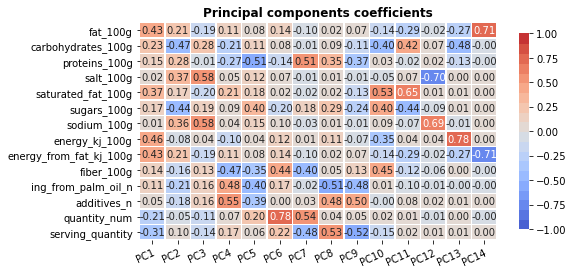

In [73]:
# Plotting principal components coefficient

plot_heatmap(pca_df,'Principal components coefficients', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),figsize=(8,4),shape='rect')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_1_principal_components.png',
                             dpi=400);
plt.show()

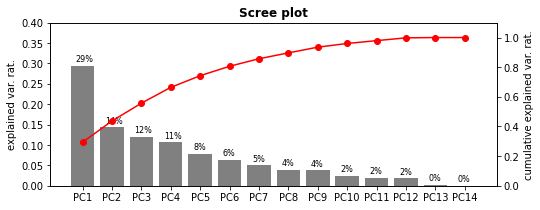

In [74]:
# Plotting explained variance ratio in scree plot

exp_var_rat = pca.explained_variance_ratio_
plt.bar(x=pca_df.columns, height=exp_var_rat, color='grey')
ax1 = plt.gca()
ax1.set(ylim=(0,0.4))
ax2 = ax1.twinx()
ax2.plot(exp_var_rat.cumsum(), 'ro-')
ax2.set(ylim=(0,1.1))
ax1.set_ylabel('explained var. rat.')
ax2.set_ylabel('cumulative explained var. rat.')

for i, p in enumerate(ax1.patches):
    ax1.text( p.get_width()/5 + p.get_x(), p.get_height()+ p.get_y()+0.01,
             '{:.0f}%'.format(exp_var_rat[i]*100),
                fontsize=8, color='k')
    
plt.gcf().set_size_inches(8,3)
plt.title('Scree plot', fontweight='bold')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_1_scree_plot.png',
                             dpi=400);
plt.show()

The shape of the curve of cumulated explained ratio does not show an elbow. However, first principal component accounts for 4 times of the ratio of 1/14 % (8.3%) of the total variance, indicating that the primary component is relevant.

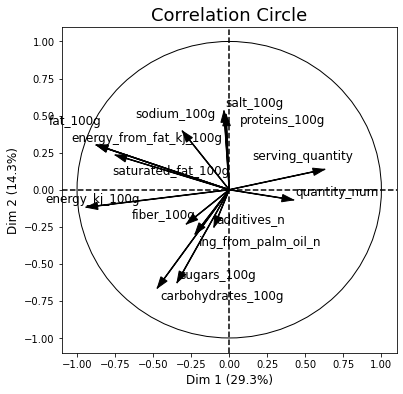

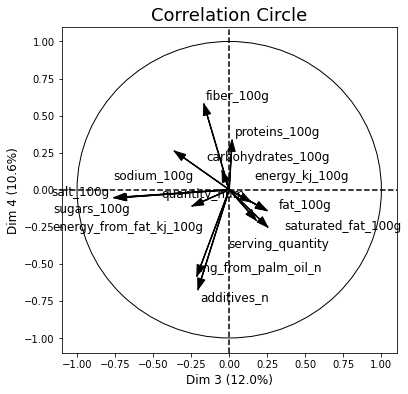

In [77]:
# POUR RECALCULER LA PCA AVEC MLXTEND

from mlxtend.plotting import plot_pca_correlation_graph

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(1, 2), figure_axis_size=6)
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(3, 4), figure_axis_size=6)

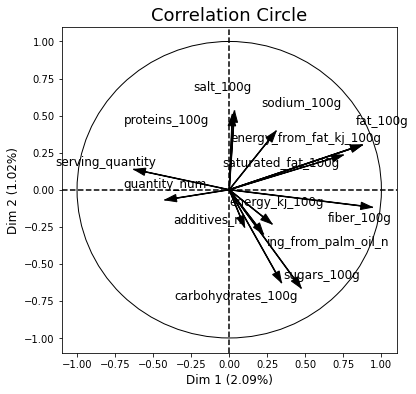

In [84]:
# Using the pca above computed (PC1, PC2)

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc,
                                variables_names = pca_cols,
                                dimensions = (1, 2),
                                figure_axis_size = 6,
                                X_pca = X_proj[:,0:2],
                                explained_variance = pca.explained_variance_ratio_[0:2])

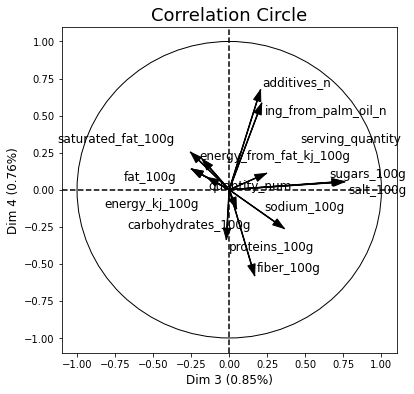

In [93]:
# Using the pca above computed (PC3, PC4)

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc,
                                variables_names = pca_cols,
                                dimensions=(3, 4),
                                figure_axis_size=6,
                                X_pca = X_proj[:,0:4],
                                explained_variance = pca.explained_variance_ratio_[0:4])

In [94]:
correlation_matrix

Dim 1     Dim 2     Dim 3     Dim 4
fat_100g                 0.872751  0.301761 -0.247072  0.139758
carbohydrates_100g       0.472164 -0.662882  0.360666 -0.260815
proteins_100g            0.307635  0.395418 -0.018877 -0.334116
salt_100g                0.034593  0.530632  0.749078  0.056017
saturated_fat_100g       0.748237  0.233933 -0.253651  0.252652
sugars_100g              0.342697 -0.625822  0.244078  0.110283
sodium_100g              0.020720  0.506249  0.758220  0.053478
energy_kj_100g           0.939666 -0.118211  0.047103 -0.127305
energy_from_fat_kj_100g  0.872751  0.301761 -0.247072  0.139758
fiber_100g               0.280878 -0.230708  0.166769 -0.578244
ing_from_palm_oil_n      0.224091 -0.298468  0.212910  0.583027
additives_n              0.100443 -0.251100  0.205509  0.672997
quantity_num            -0.421898 -0.068816 -0.144151  0.083089
serving_quantity        -0.626084  0.137114 -0.177337  0.206123

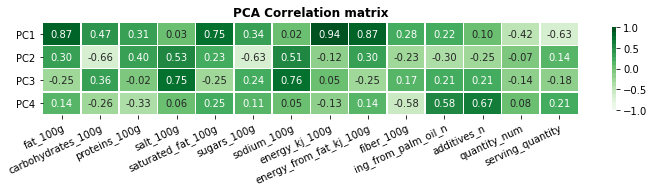

In [95]:
# Plotting the PCA correlation matrix

plot_heatmap(correlation_matrix.T,'PCA Correlation matrix', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("Greens", 20),figsize=(12,1.7),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4'])
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_1_correaltion_matrix.png',
                             dpi=400);
plt.show()

In [96]:
# Plotting a sample of values projected on first factorial planes

id_code_samp = pd.Series(id_code).sample(300)
X_samp = df.loc[id_code_samp, pca_cols].values
X_sc_samp = StandardScaler().fit_transform(X_samp)

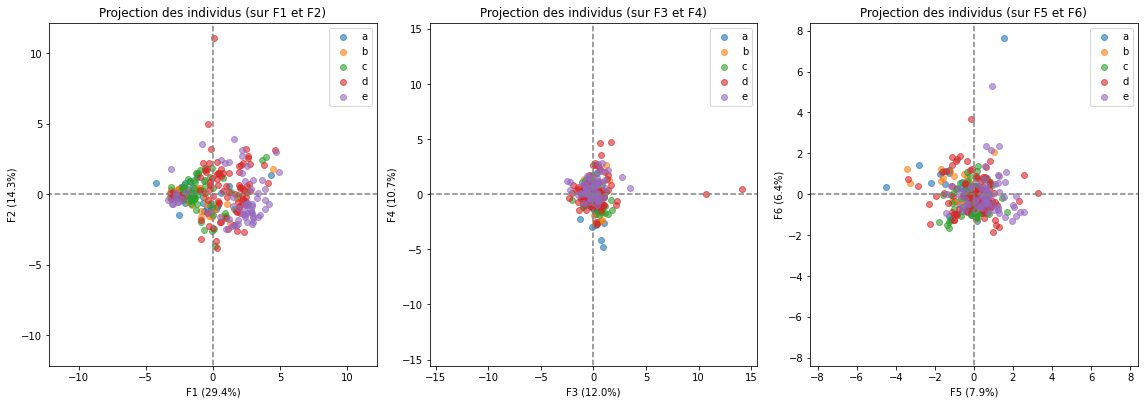

In [97]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'nutrigrade'],
                         lab_on=False, alpha=0.6)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_factor_planes1.png',
                             dpi=400);
plt.show()

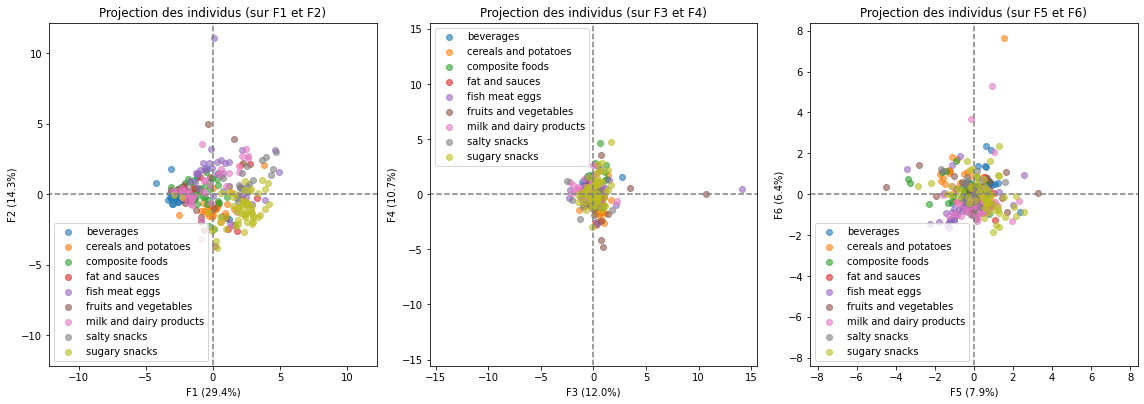

In [98]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'pnns1'],
                         lab_on=False, alpha=0.6)
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_factor_planes2.png',
                             dpi=400);
plt.show()

### 4.2 Clustering
The four first PC (Principal Components) account for 73 % of the total variance. We'll keep these 4 and try to find clusters.

In [99]:
## KMeans Clustering

n_clust = 5
km = KMeans(n_clusters=n_clust).fit(X_proj)
clustK = km.labels_
df.loc[id_code, 'cluster_Kmeans'] = clustK

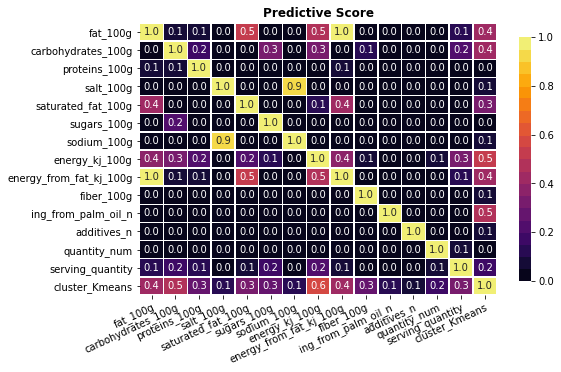

In [100]:
# Sampled Predictive Power Score (ppscore)

cols = pca_cols + ['cluster_Kmeans']

pps_corr = pps.matrix(df[cols])
plot_heatmap(pps_corr, title="Predictive Score", 
             vmin=0, center=0.5, figsize=(8,5), shape='rect',
             palette=sns.color_palette("inferno", 20), fmt='.1f')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_ppscore_clusters.png', dpi=400);
plt.show()

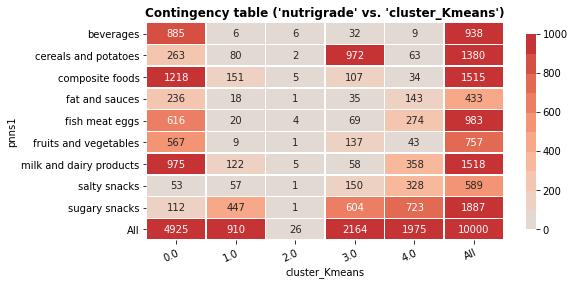

In [101]:
## Creating table of contingency

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)

plot_heatmap(data_crosstab,"Contingency table ('nutrigrade' vs. 'cluster_Kmeans')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8,4), shape='rect', fmt='.0f')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_nutrig_clusters.png', dpi=400);
plt.show()

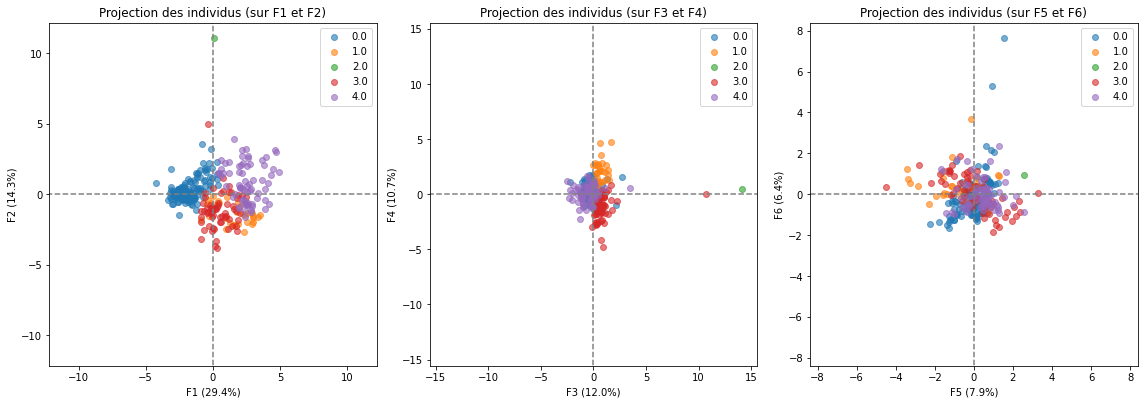

In [102]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'cluster_Kmeans'],
                         lab_on=False, alpha=0.6)

if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_3_1_factor_planes3.png',
                             dpi=400);
plt.show()

---Chi-squared
stat=6433.003, p=0.000
Probably dependent


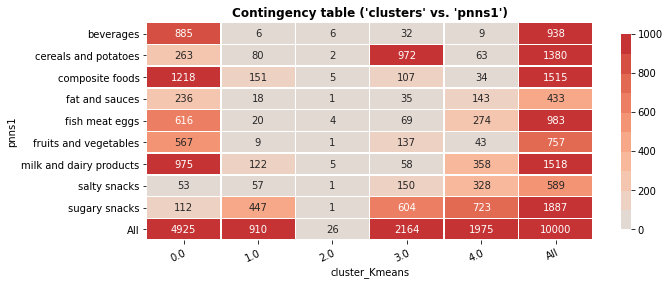

In [103]:
# Contingency table showing cluster vs. pnns1 categories

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)
# display(data_crosstab

# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(data_crosstab,"Contingency table ('clusters' vs. 'pnns1')",
             vmin=0, vmax=1000,figsize=(10,4),shape='rect', fmt='.0f',
             palette=sns.color_palette("coolwarm", 20))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_cont_tabl_clust_pnns1.png',
                             dpi=400);
plt.show()

In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

In [104]:
!pip freeze > requirements_analysis.txt